In [ ]:
!pip install transformers torch sentencepiece sacremoses
pip install pandas numpy scikit-learn jellyfish sentence-transformers torch
!pip install tf-keras

# Add this cell BEFORE your preprocessing code

import pandas as pd
import re
from collections import Counter
from typing import Dict, List, Set

def analyze_trademark_vocabulary(csv_path: str, top_n: int = 100) -> Dict:
    """
    Analyze your trademark dataset to extract frequent words for lexicon building
    
    Args:
        csv_path: Path to trademark CSV file
        top_n: How many top words to extract
    
    Returns:
        Dictionary with analysis results
    """
    print("=" * 80)
    print("TRADEMARK VOCABULARY ANALYSIS")
    print("=" * 80)
    
    # Load dataset
    df = pd.read_csv(csv_path, encoding='MacRoman')
    
    # Extract wordmark columns
    wordmarks = []
    if 'Name RM' in df.columns:
        wordmarks.extend(df['Name RM'].dropna().astype(str).tolist())
    if 'Name TM' in df.columns:
        wordmarks.extend(df['Name TM'].dropna().astype(str).tolist())
    
    print(f"\n📊 Dataset Overview:")
    print(f"   Total trademark pairs: {len(df)}")
    print(f"   Total wordmarks extracted: {len(wordmarks)}")
    
    # Tokenize and count words
    all_words = []
    for mark in wordmarks:
        # Clean and tokenize
        mark = mark.lower()
        # Remove special characters but keep letters
        words = re.findall(r'\b[a-záéíóúâêôãõçüï]+\b', mark)
        all_words.extend(words)
    
    # Count frequencies
    word_freq = Counter(all_words)
    
    print(f"\n📝 Vocabulary Statistics:")
    print(f"   Total words (with repetition): {len(all_words)}")
    print(f"   Unique words: {len(word_freq)}")
    print(f"   Average word length: {sum(len(w) for w in word_freq.keys()) / len(word_freq):.1f} chars")
    
    # Get top N words
    top_words = word_freq.most_common(top_n)
    
    print(f"\n🔝 Top {min(50, len(top_words))} Most Frequent Words:")
    print("-" * 80)
    for i, (word, count) in enumerate(top_words[:50], 1):
        print(f"{i:3d}. {word:20s} → {count:5d} occurrences")
    
    # Categorize words by domain
    print(f"\n🏷️  Categorized Terms:")
    categories = {
        'business': ['empresa', 'comercio', 'loja', 'mercado', 'servicos', 'industria'],
        'quality': ['premium', 'super', 'mega', 'ultra', 'top', 'best', 'melhor'],
        'location': ['brasil', 'rio', 'são', 'paulo', 'nacional', 'internacional'],
        'food': ['cafe', 'food', 'pizza', 'restaurante', 'padaria', 'casa'],
        'fashion': ['moda', 'fashion', 'style', 'wear', 'roupa'],
        'tech': ['tech', 'digital', 'smart', 'web', 'online', 'net'],
    }
    
    for category, keywords in categories.items():
        category_words = [w for w, _ in top_words if any(kw in w for kw in keywords)]
        if category_words:
            print(f"   {category.capitalize():15s}: {', '.join(category_words[:10])}")
    
    # Return analysis results
    return {
        'top_words': top_words,
        'word_freq': word_freq,
        'total_unique': len(word_freq),
        'categorized': categories
    }

# Run the analysis
vocab_analysis = analyze_trademark_vocabulary('trademark_file.csv', top_n=200)

# Latest
##NEWWWWWWWWWWWWWWWWW
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple
import re
import logging
from dataclasses import dataclass
from deep_translator import GoogleTranslator
import chardet  # For encoding detection
import os
import re

def get_incremented_filename(base_name: str) -> str:
    """
    Returns an incremented filename if the file already exists.
    Example:
      - 'data.csv' → 'data_1.csv' → 'data_2.csv' ...
    """
    if not os.path.exists(base_name):
        return base_name

    # Split name and extension
    name, ext = os.path.splitext(base_name)
    
    # Check for existing numbered versions
    counter = 1
    while True:
        new_name = f"{name}_{counter}{ext}"
        if not os.path.exists(new_name):
            return new_name
        counter += 1

# Add this near the top of your file (after imports)
TRADEMARK_LEXICON = {
    # ========== BUSINESS & COMMERCE ==========
    "company": {"ha": "kamfani", "yo": "ilé-iṣẹ́"},
    "business": {"ha": "kasuwanci", "yo": "iṣẹ́ owó"},
    "commerce": {"ha": "kasuwanci", "yo": "ìṣòwò"},
    "market": {"ha": "kasuwa", "yo": "ọjà"},
    "store": {"ha": "shago", "yo": "ṣọ́ọ̀bù"},
    "shop": {"ha": "shago", "yo": "ṣọ́ọ̀bù"},
    "trade": {"ha": "ciniki", "yo": "ìṣòwò"},
    "service": {"ha": "sabis", "yo": "ìṣẹ́"},
    "services": {"ha": "ayyuka", "yo": "àwọn iṣẹ́"},
    "brand": {"ha": "alama", "yo": "àmì"},
    "logo": {"ha": "tambari", "yo": "àmì"},
    
    # ========== QUALITY DESCRIPTORS ==========
    "premium": {"ha": "mai kyau", "yo": "iyebíye"},
    "super": {"ha": "babba", "yo": "púpọ̀"},
    "mega": {"ha": "babba sosai", "yo": "ńlá púpọ̀"},
    "ultra": {"ha": "mafi", "yo": "jùlọ"},
    "best": {"ha": "mafi kyau", "yo": "dára jùlọ"},
    "top": {"ha": "sama", "yo": "òkè"},
    "elite": {"ha": "zaɓaɓɓu", "yo": "àṣàyàn"},
    "royal": {"ha": "sarauta", "yo": "ọba"},
    "gold": {"ha": "zinariya", "yo": "wúrà"},
    "silver": {"ha": "azurfa", "yo": "fàdákà"},
    "diamond": {"ha": "lu'ulu'u", "yo": "òkúta iyebíye"},
    "original": {"ha": "asali", "yo": "àtọwọ́dọ́wọ́"},
    "classic": {"ha": "na gargajiya", "yo": "ìbílẹ̀"},
    "modern": {"ha": "na zamani", "yo": "ọ̀dẹ"},
    "new": {"ha": "sabon", "yo": "títun"},
    "fresh": {"ha": "sabo", "yo": "tuntun"},
    "natural": {"ha": "na halitta", "yo": "àdáyébá"},
    "organic": {"ha": "kwayoyi na halitta", "yo": "ọganiki"},
    
    # ========== FOOD & BEVERAGE ==========
    "coffee": {"ha": "kofi", "yo": "kọ́fí"},
    "tea": {"ha": "shayi", "yo": "tii"},
    "food": {"ha": "abinci", "yo": "oúnjẹ"},
    "restaurant": {"ha": "gidan cin abinci", "yo": "ilé oúnjẹ"},
    "cafe": {"ha": "kantin kofi", "yo": "ilé kọ́fí"},
    "bakery": {"ha": "gidan burodi", "yo": "ilé búrẹ́dì"},
    "pizza": {"ha": "pizza", "yo": "pítísà"},
    "burger": {"ha": "burger", "yo": "bọ́gà"},
    "bread": {"ha": "burodi", "yo": "búrẹ́dì"},
    "meat": {"ha": "nama", "yo": "ẹran"},
    "milk": {"ha": "madara", "yo": "wàrà"},
    "juice": {"ha": "ruwan 'ya'yan itace", "yo": "omi èso"},
    "water": {"ha": "ruwa", "yo": "omi"},
    "drink": {"ha": "abin sha", "yo": "ohun mímu"},
    "sweet": {"ha": "mai dadi", "yo": "dídùn"},
    "delicious": {"ha": "mai dadi", "yo": "dídùn"},
    
    # ========== FASHION & CLOTHING ==========
    "fashion": {"ha": "salon", "yo": "àṣà aṣọ"},
    "style": {"ha": "salo", "yo": "àṣà"},
    "wear": {"ha": "sawa", "yo": "wọ̀"},
    "clothing": {"ha": "tufafi", "yo": "aṣọ"},
    "dress": {"ha": "riga", "yo": "aṣọ"},
    "shirt": {"ha": "riga", "yo": "ṣẹ́tù"},
    "shoes": {"ha": "takalma", "yo": "bàtà"},
    "hat": {"ha": "hula", "yo": "fìlà"},
    "bag": {"ha": "jaka", "yo": "àpò"},
    "accessories": {"ha": "kayan ado", "yo": "ohun ọ̀ṣọ́"},
    
    # ========== TECHNOLOGY ==========
    "tech": {"ha": "fasaha", "yo": "ìmọ̀-ẹrọ"},
    "technology": {"ha": "fasahar zamani", "yo": "ìmọ̀-ẹrọ"},
    "digital": {"ha": "na dijital", "yo": "oníjìtù"},
    "smart": {"ha": "mai hankali", "yo": "ológbọ́n"},
    "online": {"ha": "kan layi", "yo": "lórí ayélujára"},
    "internet": {"ha": "yanar gizo", "yo": "íńtánẹ́ẹ̀tì"},
    "app": {"ha": "app", "yo": "ìṣàmúlò"},
    "software": {"ha": "software", "yo": "sọ́fìtíwíà"},
    "web": {"ha": "yanar gizo", "yo": "wẹ́ẹ̀bù"},
    "mobile": {"ha": "wayar hannu", "yo": "fóònù alágbèéká"},
    "phone": {"ha": "waya", "yo": "fóònù"},
    "computer": {"ha": "kwamfuta", "yo": "kọ̀mpútà"},
    
    # ========== LOCATION & GEOGRAPHY ==========
    "brazil": {"ha": "Brazil", "yo": "Brazil"},
    "brazilian": {"ha": "na Brazil", "yo": "ará Brazil"},
    "city": {"ha": "birni", "yo": "ìlú"},
    "house": {"ha": "gida", "yo": "ilé"},
    "home": {"ha": "gida", "yo": "ilé"},
    "place": {"ha": "wuri", "yo": "ibì"},
    "center": {"ha": "cibiyar", "yo": "àárín"},
    "plaza": {"ha": "filin", "yo": "gbàgede"},
    
    # ========== SIZE & QUANTITY ==========
    "big": {"ha": "babba", "yo": "ńlá"},
    "small": {"ha": "ƙarami", "yo": "kékeré"},
    "large": {"ha": "babba", "yo": "ńlá"},
    "mini": {"ha": "ƙanƙanta", "yo": "kéékèèké"},
    "maxi": {"ha": "babba sosai", "yo": "tóbi"},
    "extra": {"ha": "ƙari", "yo": "àfikún"},
    "plus": {"ha": "da ƙari", "yo": "àfikún"},
    
    # ========== TIME & STATUS ==========
    "new": {"ha": "sabon", "yo": "títun"},
    "old": {"ha": "tsoho", "yo": "àtijọ́"},
    "now": {"ha": "yanzu", "yo": "báyìí"},
    "today": {"ha": "yau", "yo": "òní"},
    "fast": {"ha": "sauri", "yo": "yára"},
    "quick": {"ha": "sauri", "yo": "yára"},
    "express": {"ha": "gaggawa", "yo": "kíákíá"},
    
    # ========== COLORS ==========
    "red": {"ha": "ja", "yo": "pupa"},
    "blue": {"ha": "shuɗi", "yo": "búlúù"},
    "green": {"ha": "kore", "yo": "aláwọ̀ ewé"},
    "yellow": {"ha": "rawaya", "yo": "oníbùdó"},
    "white": {"ha": "fari", "yo": "funfun"},
    "black": {"ha": "baƙi", "yo": "dúdú"},
    
    # ========== COMMON ACTIONS ==========
    "buy": {"ha": "saya", "yo": "rà"},
    "sell": {"ha": "sayar", "yo": "tà"},
    "make": {"ha": "yi", "yo": "ṣe"},
    "create": {"ha": "ƙirƙira", "yo": "dá"},
    "build": {"ha": "gina", "yo": "kọ́"},
    "design": {"ha": "ƙira", "yo": "yàwòrán"},
    "repair": {"ha": "gyara", "yo": "tún"},
    "fix": {"ha": "gyara", "yo": "tún"},
    
    # ========== COMMON NOUNS ==========
    "king": {"ha": "sarki", "yo": "ọba"},
    "queen": {"ha": "sarauniya", "yo": "ayaba"},
    "people": {"ha": "mutane", "yo": "àwọn ènìyàn"},
    "woman": {"ha": "mace", "yo": "obìnrin"},
    "man": {"ha": "mutum", "yo": "ọkùnrin"},
    "child": {"ha": "yaro", "yo": "ọmọdé"},
    "family": {"ha": "iyali", "yo": "ẹbí"},
    "friend": {"ha": "aboki", "yo": "ọ̀rẹ́"},
    "love": {"ha": "ƙauna", "yo": "ìfẹ́"},
    "life": {"ha": "rayuwa", "yo": "ìgbésí ayé"},
    "world": {"ha": "duniya", "yo": "ayé"},
    
    # Add more based on your dataset analysis...
}

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# Add this BEFORE the BrazilianTrademarkPreprocessor class

from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

class EnhancedTranslator:
    """
    Multi-strategy translator with:
    1. Domain-specific lexicon (fastest)
    2. HuggingFace models (better quality)
    3. Google Translate (fallback)
    """
    
    def __init__(self):
        self.lexicon = TRADEMARK_LEXICON
        self.hf_models = {}
        self.google_translators = {
            'ha': GoogleTranslator(source='en', target='ha'),
            'yo': GoogleTranslator(source='en', target='yo')
        }
        self.translation_cache = {}
        self.stats = {'lexicon': 0, 'huggingface': 0, 'google': 0, 'cache': 0}
        
        # Try to load HuggingFace models (optional)
        self._load_hf_models()
    
    def _load_hf_models(self):
        """
        Load HuggingFace translation models for Yoruba/Hausa
        Falls back gracefully if models not available
        """
        try:
            # Facebook's NLLB model supports 200+ languages including Yoruba
            print("Loading HuggingFace models...")
            self.hf_models['yo'] = pipeline(
                "translation", 
                model="facebook/nllb-200-distilled-600M",
                src_lang="eng_Latn",
                tgt_lang="yor_Latn"
            )
            print("✓ Loaded Yoruba model (NLLB)")
        except Exception as e:
            print(f"⚠ HuggingFace Yoruba model not available: {e}")
            print("  Will use Google Translate fallback")
        
        try:
            # Hausa model
            self.hf_models['ha'] = pipeline(
                "translation",
                model="facebook/nllb-200-distilled-600M",
                src_lang="eng_Latn",
                tgt_lang="hau_Latn"
            )
            print("✓ Loaded Hausa model (NLLB)")
        except Exception as e:
            print(f"⚠ HuggingFace Hausa model not available: {e}")
            print("  Will use Google Translate fallback")
    
    def translate_word(self, word: str, target_lang: str) -> str:
        """
        Translate a single word using multi-strategy approach
        Priority: Lexicon → HuggingFace → Google Translate
        """
        if not word or not word.strip():
            return word
        
        word_lower = word.lower().strip()
        cache_key = f"{target_lang}:{word_lower}"
        
        # 1. Check cache
        if cache_key in self.translation_cache:
            self.stats['cache'] += 1
            return self.translation_cache[cache_key]
        
        # 2. Try lexicon (fastest and most accurate for domain terms)
        if word_lower in self.lexicon:
            translation = self.lexicon[word_lower].get(target_lang, word)
            self.stats['lexicon'] += 1
            self.translation_cache[cache_key] = translation
            return translation
        
        # 3. Try HuggingFace model (better than Google for African languages)
        if target_lang in self.hf_models:
            try:
                result = self.hf_models[target_lang](word)
                translation = result[0]['translation_text']
                self.stats['huggingface'] += 1
                self.translation_cache[cache_key] = translation
                return translation
            except Exception as e:
                pass  # Fall through to Google Translate
        
        # 4. Fallback to Google Translate
        try:
            translation = self.google_translators[target_lang].translate(word)
            self.stats['google'] += 1
            self.translation_cache[cache_key] = translation
            return translation
        except Exception as e:
            # Ultimate fallback: return original
            return word
    
    def translate_text(self, text: str, target_lang: str) -> str:
        """
        Translate full text word-by-word
        """
        if pd.isna(text) or not text:
            return ""
        
        words = re.findall(r"\b\w+\b", str(text))
        translated_words = []
        
        for word in words:
            trans = self.translate_word(word, target_lang)
            translated_words.append(trans)
        
        return " ".join(translated_words)
    
    def get_stats(self) -> Dict:
        """Get translation statistics"""
        total = sum(self.stats.values())
        return {
            **self.stats,
            'total': total,
            'lexicon_pct': (self.stats['lexicon'] / total * 100) if total > 0 else 0,
            'hf_pct': (self.stats['huggingface'] / total * 100) if total > 0 else 0,
            'google_pct': (self.stats['google'] / total * 100) if total > 0 else 0,
            'cache_pct': (self.stats['cache'] / total * 100) if total > 0 else 0
        }

# Initialize enhanced translator
enhanced_translator = EnhancedTranslator()
@dataclass
class PreprocessingConfig:
    """Configuration for preprocessing strategy"""
    fix_encoding: bool = True
    translate_to_english: bool = True
    translate_to_local: bool = True  # HA/YO
    remove_duplicates: bool = True
    handle_missing: str = 'drop'  # 'drop' or 'fill'
     # NEW: Sampling control
    max_rows: Optional[int] = None      # e.g., 1000 → process only 1000 rows
    sampling_strategy: str = 'first'    # 'first', 'random', or 'all'


class BrazilianTrademarkPreprocessor:
    """
    Specialized preprocessor for Brazilian INPI trademark dataset
    Handles: Portuguese → English → Hausa/Yoruba translation pipeline
    """
    
    def __init__(self, config: PreprocessingConfig = None):
        self.config = config or PreprocessingConfig()
        self.original_df = None
        self.processed_df = None
        
        # Initialize translators
        self.pt_to_en = GoogleTranslator(source='pt', target='en')
        self.enhanced_translator = EnhancedTranslator()  # NEW: Use enhanced translator
        
        self.translation_cache = {}
    
    def detect_encoding(self, file_path: str) -> str:
        """
        Detect file encoding to fix those v� characters
        """
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read(100000))  # Read first 100KB
        
        detected = result['encoding']
        confidence = result['confidence']
        
        logger.info(f"Detected encoding: {detected} (confidence: {confidence:.2%})")
        return detected
    
    def _get_lexicon_translation(self, word: str, target_lang: str) -> Optional[str]:
        """
        Get translation from domain lexicon (case-insensitive)
        target_lang: 'ha' or 'yo'
        """
        word_lower = word.lower().strip()
        if word_lower in TRADEMARK_LEXICON:
            return TRADEMARK_LEXICON[word_lower].get(target_lang)
        return None

    def translate_word_with_fallback(self, word: str, target_lang: str) -> str:
        """
        Translate a single word using lexicon first, then Google Translate
        """
        if not word or not word.strip():
            return word
        
        # 1. Try domain lexicon
        lex_trans = self._get_lexicon_translation(word, target_lang)
        if lex_trans:
            return lex_trans
        
        # 2. Fallback to Google Translate
        translator = self.en_to_ha if target_lang == 'ha' else self.en_to_yo
        cache_key = f"en_{target_lang}"
        return self.translate_with_cache(word, translator, cache_key)

    def translate_text_lexicon_first(self, text_en: str, target_lang: str) -> str:
        """
        Translate using enhanced multi-strategy translator
        """
        return self.enhanced_translator.translate_text(text_en, target_lang)

    def load_and_fix_encoding(self, file_path: str) -> pd.DataFrame:
        """
        Load CSV with proper encoding detection and fixing
        """
        # Try to detect encoding
        try:
            encoding = self.detect_encoding(file_path)
        except Exception as e:
            logger.warning(f"Encoding detection failed: {e}. Trying latin-1...")
            encoding = 'latin-1'
        
        # Try loading with detected encoding
        encodings_to_try = [encoding, 'utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(file_path, encoding=enc)
                logger.info(f"✓ Successfully loaded with encoding: {enc}")
                self.original_df = df
                return df
            except Exception as e:
                logger.debug(f"Failed with {enc}: {e}")
                continue
        
        raise ValueError("Could not load CSV with any common encoding")
    
    def extract_relevant_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract and rename relevant columns from Brazilian dataset
        
        Original columns:
        - Process number RM, Name RM, Status RM, etc. (Registered Mark)
        - Process number TM, Name TM, Status TM, etc. (Target Mark - the contested one)
        """
        
        # Map to standardized column names
        column_mapping = {
            # Pair identification
            'Process number RM': 'mark1_id',
            'Process number TM': 'mark2_id',
            
            # Wordmarks (the actual text)
            'Name RM': 'mark1_wordmark',
            'Name TM': 'mark2_wordmark',
            
            # Status
            'Status RM': 'mark1_status',
            'Status TM': 'mark2_status',
            
            # Classification
            'Nice classification RM': 'mark1_class',
            'Nice classification TM': 'mark2_class',
            
            # Presentation (Nominative/Mixed/Figurative)
            'Presentation RM': 'mark1_presentation',
            'Presentation TM': 'mark2_presentation',
            
            # Date
            'Application date RM': 'mark1_date',
            'Application date TM': 'mark2_date',
            
            # Complementary text (explains why similar)
            'Complementary text': 'similarity_reason'
        }
        
        # Select and rename columns
        available_cols = [col for col in column_mapping.keys() if col in df.columns]
        df_processed = df[available_cols].copy()
        df_processed.rename(columns=column_mapping, inplace=True)
        
        # Add label: these pairs are SIMILAR (that's why they're in the rejection dataset)
        df_processed['label'] = 1  # 1 = similar/confusing
        
        logger.info(f"✓ Extracted {len(df_processed)} trademark pairs")
        logger.info(f"   Columns: {list(df_processed.columns)}")
        
        return df_processed
    
    def clean_text(self, text: str) -> str:
        """
        Clean trademark text
        - Remove extra whitespace
        - Fix common encoding artifacts
        - Normalize
        """
        if pd.isna(text) or text == '':
            return ''
        
        text = str(text)
        
        # Fix common encoding issues
        encoding_fixes = {
            'v�': 'ç',
            'v�o': 'ção',
            'v�': 'í',
            'v=': 'ó',
            '?': '',  # Remove question marks from encoding errors
        }
        
        for bad, good in encoding_fixes.items():
            text = text.replace(bad, good)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text.strip()
    
    def translate_with_cache(self, text: str, translator, cache_key: str) -> str:
        """
        Translate text with caching to avoid redundant API calls
        """
        if not text or text == '':
            return ''
        
        # Check cache
        cache_id = f"{cache_key}:{text}"
        if cache_id in self.translation_cache:
            return self.translation_cache[cache_id]
        
        # Translate
        try:
            translation = translator.translate(text)
            self.translation_cache[cache_id] = translation
            return translation
        except Exception as e:
            logger.warning(f"Translation failed for '{text[:50]}...': {e}")
            return text  # Return original on failure
    
    def translate_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Translate wordmarks: Portuguese → English → [Hausa/Yoruba via lexicon + fallback]
        """
        logger.info("🌍 Starting translation pipeline...")
        
        wordmark_cols = ['mark1_wordmark', 'mark2_wordmark']
        
        for col in wordmark_cols:
            if col not in df.columns:
                continue
            
            logger.info(f"   Translating {col}...")
            
            # Portuguese → English (unchanged)
            if self.config.translate_to_english:
                en_col = col.replace('_wordmark', '_wordmark_en')
                df[en_col] = df[col].apply(
                    lambda x: self.translate_with_cache(
                        self.clean_text(x), 
                        self.pt_to_en, 
                        'pt_en'
                    )
                )
                logger.info(f"      ✓ Portuguese → English: {en_col}")
            
            # English → Hausa & Yoruba (enhanced)
            if self.config.translate_to_local:
                # Hausa
                ha_col = col.replace('_wordmark', '_wordmark_ha')
                df[ha_col] = df[en_col].apply(
                    lambda x: self.translate_text_lexicon_first(str(x), 'ha')
                )
                logger.info(f"      ✓ English → Hausa (lexicon+fallback): {ha_col}")
                
                # Yoruba
                yo_col = col.replace('_wordmark', '_wordmark_yo')
                df[yo_col] = df[en_col].apply(
                    lambda x: self.translate_text_lexicon_first(str(x), 'yo')
                )
                logger.info(f"      ✓ English → Yoruba (lexicon+fallback): {yo_col}")
        
        return df
    
    def handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Handle missing values based on configuration
        """
        initial_count = len(df)
        
        if self.config.handle_missing == 'drop':
            # Drop rows where critical columns are missing
            critical_cols = ['mark1_wordmark', 'mark2_wordmark']
            df = df.dropna(subset=critical_cols)
            removed = initial_count - len(df)
            if removed > 0:
                logger.info(f"⚠ Removed {removed} rows with missing wordmarks")
        
        return df
    
    def remove_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Remove duplicate trademark pairs
        """
        if not self.config.remove_duplicates:
            return df
        
        initial_count = len(df)
        
        # Sort pairs to avoid (A,B) vs (B,A) duplicates
        df['pair_key'] = df.apply(
            lambda row: tuple(sorted([
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ])),
            axis=1
        )
        
        df = df.drop_duplicates(subset='pair_key')
        df = df.drop('pair_key', axis=1)
        
        removed = initial_count - len(df)
        if removed > 0:
            logger.info(f"⚠ Removed {removed} duplicate pairs")
        
        return df
    
    def add_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add basic features for later use
        """
        # Length features
        df['mark1_length'] = df['mark1_wordmark'].str.len()
        df['mark2_length'] = df['mark2_wordmark'].str.len()
        
        # Same class indicator
        df['same_class'] = (df['mark1_class'] == df['mark2_class']).astype(int)
        
        # Length difference
        df['length_diff'] = abs(df['mark1_length'] - df['mark2_length'])
        
        return df
    
    def _sample_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Sample the dataframe based on config: first N, random N, or all.
        Applied AFTER loading but BEFORE heavy processing (cleaning, translation).
        """

        if self.config.max_rows is not None and self.config.max_rows <= 0:
            raise ValueError("max_rows must be positive integer or None")
        
        if self.config.sampling_strategy == 'all' or self.config.max_rows is None:
            logger.info("📝 Sampling strategy: using all rows")
            return df

        n = min(self.config.max_rows, len(df))
        
        if self.config.sampling_strategy == 'first':
            sampled_df = df.head(n).copy()
            logger.info(f"📝 Sampling strategy: first {n} rows")
            
        elif self.config.sampling_strategy == 'random':
            sampled_df = df.sample(n=n, random_state=42).copy()  # reproducible
            logger.info(f"📝 Sampling strategy: random {n} rows (seed=42)")
            
        else:
            raise ValueError(f"Unknown sampling strategy: {self.config.sampling_strategy}")
        
        return sampled_df

    def process(self, file_path: str) -> pd.DataFrame:
        """
        Full preprocessing pipeline
        """
        logger.info("=" * 80)
        logger.info("BRAZILIAN TRADEMARK DATASET PREPROCESSING")
        logger.info("=" * 80)
        
        # 1. Load with encoding fix
        logger.info("\n1️⃣ Loading dataset...")
        df = self.load_and_fix_encoding(file_path)
        logger.info(f"   Loaded: {df.shape}")
        
        # 2. Extract relevant columns
        logger.info("\n2️⃣ Extracting relevant columns...")
        df = self.extract_relevant_columns(df)
        
        # >>> NEW: Apply sampling here <<<
        logger.info("\n3️⃣ Applying sampling strategy...")
        df = self._sample_dataframe(df)
        logger.info(f"   After sampling: {df.shape}")

        # 3. Clean text
        logger.info("\n3️⃣ Cleaning text...")
        for col in df.columns:
            if 'wordmark' in col or 'reason' in col:
                df[col] = df[col].apply(self.clean_text)
        
        # 4. Handle missing values
        logger.info("\n4️⃣ Handling missing values...")
        df = self.handle_missing_values(df)
        
        # 5. Remove duplicates
        logger.info("\n5️⃣ Removing duplicates...")
        df = self.remove_duplicates(df)
        
        # 6. Translate
        logger.info("\n6️⃣ Translating dataset...")
        df = self.translate_dataset(df)
        
        # 7. Add features
        logger.info("\n7️⃣ Adding features...")
        df = self.add_features(df)
        
        self.processed_df = df
        
        logger.info("\n" + "=" * 80)
        logger.info(f"✅ PREPROCESSING COMPLETE")
        logger.info(f"   Final dataset: {df.shape}")
        logger.info(f"   Columns: {list(df.columns)}")
        logger.info("=" * 80)
        
        # After processing, show translation stats
        stats = self.enhanced_translator.get_stats()
        logger.info("\n📊 Translation Statistics:")
        logger.info(f"   Lexicon hits: {stats['lexicon']} ({stats['lexicon_pct']:.1f}%)")
        logger.info(f"   HuggingFace: {stats['huggingface']} ({stats['hf_pct']:.1f}%)")
        logger.info(f"   Google Translate: {stats['google']} ({stats['google_pct']:.1f}%)")
        logger.info(f"   Cache hits: {stats['cache']} ({stats['cache_pct']:.1f}%)")
        
        return df
    
    def get_sample_report(self, n: int = 10) -> pd.DataFrame:
        """
        Get sample of processed data for inspection
        """
        if self.processed_df is None:
            raise ValueError("No processed data. Run process() first.")
        
        cols_to_show = [
            'mark1_wordmark', 'mark1_wordmark_en', 'mark1_wordmark_ha', 'mark1_wordmark_yo',
            'mark2_wordmark', 'mark2_wordmark_en', 'mark2_wordmark_ha', 'mark2_wordmark_yo',
            'label', 'same_class'
        ]
        
        available_cols = [col for col in cols_to_show if col in self.processed_df.columns]
        
        return self.processed_df[available_cols].head(n)
    
    def save_processed(self, output_path: str):
        """
        Save processed dataset
        """
        if self.processed_df is None:
            raise ValueError("No processed data to save")
        
        self.processed_df.to_csv(output_path, index=False, encoding='utf-8')
        logger.info(f"✅ Saved processed dataset to: {output_path}")


    # Add these methods to the BrazilianTrademarkPreprocessor class

    def generate_negative_pairs(
        self, 
        df: pd.DataFrame, 
        ratio: float = 1.0,
        strategy: str = 'mixed'  # 'random', 'class_based', 'mixed'
    ) -> pd.DataFrame:
        """
        Generate negative (dissimilar) pairs from positive pairs
        
        Args:
            df: DataFrame with positive pairs (label=1)
            ratio: How many negative pairs to generate (1.0 = same as positive)
            strategy: 'random', 'class_based', or 'mixed'
        
        Returns:
            DataFrame with negative pairs (label=0)
        """
        logger.info(f"\n🔄 Generating negative pairs (strategy: {strategy}, ratio: {ratio})...")
        
        # Get unique wordmarks for each mark position
        mark1_pool = df['mark1_wordmark'].unique()
        mark2_pool = df['mark2_wordmark'].unique()
        
        # Combine all unique wordmarks and filter out empty/invalid ones
        all_wordmarks = list(set(list(mark1_pool) + list(mark2_pool)))
        all_wordmarks = [
            str(w).strip() for w in all_wordmarks 
            if pd.notna(w) and str(w).strip() and len(str(w).strip()) > 0
        ]
        
        if len(all_wordmarks) < 2:
            logger.error(f"❌ Not enough valid wordmarks to generate pairs. Found: {len(all_wordmarks)}")
            return pd.DataFrame()
        
        logger.info(f"   Valid wordmarks available: {len(all_wordmarks)}")
        
        # Get class information if available
        mark1_classes = df.set_index('mark1_wordmark')['mark1_class'].to_dict()
        mark2_classes = df.set_index('mark2_wordmark')['mark2_class'].to_dict()
        all_classes = {**mark1_classes, **mark2_classes}
        
        # Calculate number of negative pairs needed
        n_positive = len(df)
        n_negative = int(n_positive * ratio)
        
        logger.info(f"   Positive pairs: {n_positive}")
        logger.info(f"   Target negative pairs: {n_negative}")
        
        negative_pairs = []
        max_attempts = n_negative * 50  # Increased attempts for better success rate
        attempts = 0
        consecutive_fails = 0
        max_consecutive_fails = 100
        
        # Track existing pairs to avoid duplicates
        existing_pairs = set()
        for _, row in df.iterrows():
            try:
                mark1_str = str(row['mark1_wordmark']).strip()
                mark2_str = str(row['mark2_wordmark']).strip()
                if mark1_str and mark2_str:
                    pair = tuple(sorted([mark1_str, mark2_str]))
                    existing_pairs.add(pair)
            except Exception as e:
                logger.debug(f"Skipping invalid pair: {e}")
                continue
        
        logger.info(f"   Existing pairs to avoid: {len(existing_pairs)}")
        
        while len(negative_pairs) < n_negative and attempts < max_attempts:
            attempts += 1
            
            try:
                # Random selection
                mark1 = np.random.choice(all_wordmarks)
                mark2 = np.random.choice(all_wordmarks)
                
                # Validate marks
                if not mark1 or not mark2 or not isinstance(mark1, str) or not isinstance(mark2, str):
                    consecutive_fails += 1
                    continue
                
                mark1 = mark1.strip()
                mark2 = mark2.strip()
                
                # Skip if empty
                if not mark1 or not mark2:
                    consecutive_fails += 1
                    continue
                
                # Skip if same
                if mark1.lower() == mark2.lower():
                    consecutive_fails += 1
                    continue
                
                # Create sorted pair to check for duplicates
                pair_key = tuple(sorted([mark1, mark2]))
                
                # Skip if already exists (either as positive or already generated negative)
                if pair_key in existing_pairs:
                    consecutive_fails += 1
                    continue
                
                # Apply strategy-specific filtering
                if strategy == 'class_based':
                    # Only accept if different classes
                    class1 = all_classes.get(mark1, 0)
                    class2 = all_classes.get(mark2, 0)
                    if class1 == class2:
                        consecutive_fails += 1
                        continue
                
                elif strategy == 'mixed':
                    # Accept if: different class OR very different length OR different first letter
                    class1 = all_classes.get(mark1, 0)
                    class2 = all_classes.get(mark2, 0)
                    len1 = len(mark1)
                    len2 = len(mark2)
                    
                    # Safely get first character
                    try:
                        first1 = mark1[0].lower() if len(mark1) > 0 else ''
                        first2 = mark2[0].lower() if len(mark2) > 0 else ''
                    except (IndexError, AttributeError):
                        first1 = ''
                        first2 = ''
                    
                    # Must satisfy at least one dissimilarity criterion
                    if not (class1 != class2 or abs(len1 - len2) > 3 or (first1 and first2 and first1 != first2)):
                        consecutive_fails += 1
                        continue
                
                # If we get here, it's a valid negative pair
                existing_pairs.add(pair_key)
                consecutive_fails = 0  # Reset counter
                
                negative_pairs.append({
                    'mark1_wordmark': mark1,
                    'mark2_wordmark': mark2,
                    'mark1_class': all_classes.get(mark1, 0),
                    'mark2_class': all_classes.get(mark2, 0),
                    'label': 0,  # Dissimilar
                    'pair_type': 'negative'
                })
                
                # Progress indicator
                if len(negative_pairs) % 10 == 0:
                    logger.debug(f"   Generated {len(negative_pairs)}/{n_negative} pairs (attempt {attempts})")
            
            except Exception as e:
                logger.debug(f"Error generating pair at attempt {attempts}: {e}")
                consecutive_fails += 1
                continue
            
            # Safety check: if too many consecutive failures, stop
            if consecutive_fails >= max_consecutive_fails:
                logger.warning(f"⚠ Stopping after {consecutive_fails} consecutive failures")
                break
        
        if len(negative_pairs) == 0:
            logger.error(f"❌ Failed to generate any negative pairs after {attempts} attempts")
            logger.error(f"   Available wordmarks: {len(all_wordmarks)}")
            logger.error(f"   Sample wordmarks: {all_wordmarks[:5] if len(all_wordmarks) >= 5 else all_wordmarks}")
            return pd.DataFrame()
        
        if len(negative_pairs) < n_negative:
            logger.warning(f"⚠ Only generated {len(negative_pairs)}/{n_negative} negative pairs after {attempts} attempts")
        else:
            logger.info(f"✓ Generated {len(negative_pairs)} negative pairs in {attempts} attempts")
        
        negative_df = pd.DataFrame(negative_pairs)
        return negative_df


    def create_balanced_dataset(
        self,
        positive_df: pd.DataFrame,
        negative_ratio: float = 1.0,
        strategy: str = 'mixed'
    ) -> pd.DataFrame:
        """
        Create a balanced dataset with both positive and negative pairs
        
        Args:
            positive_df: DataFrame with positive pairs
            negative_ratio: Ratio of negative to positive pairs
            strategy: Strategy for generating negatives
        
        Returns:
            Combined balanced dataset (or just positive_df if negative generation fails)
        """
        logger.info("\n📊 Creating balanced dataset...")
        
        # Validate input
        if positive_df is None or len(positive_df) == 0:
            logger.error("❌ No positive pairs provided")
            return pd.DataFrame()
        
        # Add pair_type to positive pairs
        positive_df = positive_df.copy()
        positive_df['pair_type'] = 'positive'
        
        # Generate negative pairs
        try:
            negative_df = self.generate_negative_pairs(
                positive_df, 
                ratio=negative_ratio, 
                strategy=strategy
            )
        except Exception as e:
            logger.error(f"❌ Failed to generate negative pairs: {e}")
            logger.warning("⚠ Returning only positive pairs")
            return positive_df
        
        # Check if negative generation succeeded
        if negative_df is None or len(negative_df) == 0:
            logger.warning("⚠ No negative pairs generated. Returning only positive pairs")
            return positive_df
        
        # Align columns
        # For negative pairs, we don't have English/HA/YO translations yet
        # So we'll need to translate them too
        if 'mark1_wordmark_en' in positive_df.columns:
            try:
                logger.info("   Translating negative pairs...")
                negative_df = self._translate_negative_pairs(negative_df)
            except Exception as e:
                logger.error(f"❌ Translation failed for negative pairs: {e}")
                logger.warning("⚠ Returning only positive pairs")
                return positive_df
        
        # Add missing columns from positive pairs
        for col in positive_df.columns:
            if col not in negative_df.columns:
                try:
                    if 'mark1' in col and col != 'mark1_wordmark' and col != 'mark1_class':
                        negative_df[col] = negative_df['mark1_wordmark'].map(
                            positive_df.set_index('mark1_wordmark')[col].to_dict()
                        )
                    elif 'mark2' in col and col != 'mark2_wordmark' and col != 'mark2_class':
                        negative_df[col] = negative_df['mark2_wordmark'].map(
                            positive_df.set_index('mark2_wordmark')[col].to_dict()
                        )
                    else:
                        negative_df[col] = None
                except Exception as e:
                    logger.debug(f"Could not map column {col}: {e}")
                    negative_df[col] = None
        
        # Combine
        try:
            balanced_df = pd.concat([positive_df, negative_df], ignore_index=True)
            
            # Shuffle
            balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
            
            logger.info(f"✓ Balanced dataset created:")
            logger.info(f"   Positive pairs: {len(positive_df)} ({len(positive_df)/len(balanced_df)*100:.1f}%)")
            logger.info(f"   Negative pairs: {len(negative_df)} ({len(negative_df)/len(balanced_df)*100:.1f}%)")
            logger.info(f"   Total: {len(balanced_df)}")
            
            return balanced_df
        
        except Exception as e:
            logger.error(f"❌ Failed to combine datasets: {e}")
            logger.warning("⚠ Returning only positive pairs")
            return positive_df


    def _translate_negative_pairs(self, negative_df: pd.DataFrame) -> pd.DataFrame:
        """
        Translate negative pairs using the same pipeline as positive pairs
        """
        if negative_df is None or len(negative_df) == 0:
            return negative_df
        
        negative_df = negative_df.copy()
        
        try:
            # Build translation dictionaries from cache
            for col in ['mark1_wordmark', 'mark2_wordmark']:
                base_col = col
                
                try:
                    # English
                    en_col = col.replace('_wordmark', '_wordmark_en')
                    negative_df[en_col] = negative_df[base_col].apply(
                        lambda x: self.translate_with_cache(
                            self.clean_text(str(x)), 
                            self.pt_to_en, 
                            'pt_en'
                        ) if pd.notna(x) and str(x).strip() else ''
                    )
                except Exception as e:
                    logger.warning(f"English translation failed for {col}: {e}")
                    negative_df[en_col] = negative_df[base_col]
                
                try:
                    # Hausa
                    ha_col = col.replace('_wordmark', '_wordmark_ha')
                    negative_df[ha_col] = negative_df[en_col].apply(
                        lambda x: self.translate_text_lexicon_first(str(x), 'ha') 
                        if pd.notna(x) and str(x).strip() else ''
                    )
                except Exception as e:
                    logger.warning(f"Hausa translation failed for {col}: {e}")
                    negative_df[ha_col] = negative_df[en_col]
                
                try:
                    # Yoruba
                    yo_col = col.replace('_wordmark', '_wordmark_yo')
                    negative_df[yo_col] = negative_df[en_col].apply(
                        lambda x: self.translate_text_lexicon_first(str(x), 'yo')
                        if pd.notna(x) and str(x).strip() else ''
                    )
                except Exception as e:
                    logger.warning(f"Yoruba translation failed for {col}: {e}")
                    negative_df[yo_col] = negative_df[en_col]
        
        except Exception as e:
            logger.error(f"❌ Critical error in translation: {e}")
            raise
        
        return negative_df


    def analyze_dataset_balance(self, df: pd.DataFrame) -> Dict:
        """
        Analyze the balance and characteristics of the dataset
        """
        print("\n" + "=" * 80)
        print("DATASET BALANCE ANALYSIS")
        print("=" * 80)
        
        # Label distribution
        label_dist = df['label'].value_counts()
        print(f"\n📊 Label Distribution:")
        for label, count in label_dist.items():
            label_name = "Similar (Positive)" if label == 1 else "Dissimilar (Negative)"
            print(f"   {label_name}: {count} ({count/len(df)*100:.1f}%)")
        
        # Pair type distribution
        if 'pair_type' in df.columns:
            pair_dist = df['pair_type'].value_counts()
            print(f"\n🔄 Pair Type Distribution:")
            for ptype, count in pair_dist.items():
                print(f"   {ptype.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
        
        # Class overlap
        same_class = df['same_class'].value_counts()
        print(f"\n🏷️  Same Class Distribution:")
        for same, count in same_class.items():
            class_label = "Same Class" if same == 1 else "Different Class"
            print(f"   {class_label}: {count} ({count/len(df)*100:.1f}%)")
        
        # Length statistics by label
        print(f"\n📏 Length Statistics by Label:")
        for label in [0, 1]:
            subset = df[df['label'] == label]
            label_name = "Positive" if label == 1 else "Negative"
            avg_len1 = subset['mark1_length'].mean()
            avg_len2 = subset['mark2_length'].mean()
            avg_diff = subset['length_diff'].mean()
            print(f"   {label_name} pairs:")
            print(f"      Avg mark1 length: {avg_len1:.1f}")
            print(f"      Avg mark2 length: {avg_len2:.1f}")
            print(f"      Avg length diff: {avg_diff:.1f}")
        
        return {
            'total_pairs': len(df),
            'positive_pairs': label_dist.get(1, 0),
            'negative_pairs': label_dist.get(0, 0),
            'balance_ratio': label_dist.get(0, 0) / label_dist.get(1, 1) if label_dist.get(1, 0) > 0 else 0
        }


# ===========================
# ENHANCED USAGE WITH NEGATIVE PAIRS
# ===========================

# Configure preprocessing
config = PreprocessingConfig(
    max_rows=5,  # Process first 100 rows (or use None for all)
    sampling_strategy='random',  # 'first', 'random', or 'all'
    fix_encoding=True,
    translate_to_english=True,
    translate_to_local=True,  # Translate to HA/YO
    remove_duplicates=True,
    handle_missing='drop'
)

# Initialize preprocessor
preprocessor = BrazilianTrademarkPreprocessor(config)

# Process the dataset
try:
    # Step 1: Process positive pairs (similar trademarks)
    print("=" * 80)
    print("STEP 1: PROCESSING POSITIVE PAIRS (Similar Trademarks)")
    print("=" * 80)
    positive_df = preprocessor.process('trademark_file.csv')
    
    if positive_df is None or len(positive_df) == 0:
        raise ValueError("No positive pairs generated from preprocessing")
    
    print(f"\n✓ Positive pairs ready: {len(positive_df)}")
    
    # Step 2: Generate negative pairs (dissimilar trademarks)
    print("\n" + "=" * 80)
    print("STEP 2: GENERATING NEGATIVE PAIRS (Dissimilar Trademarks)")
    print("=" * 80)
    
    # Create balanced dataset with negative pairs
    balanced_df = preprocessor.create_balanced_dataset(
        positive_df,
        negative_ratio=1.0,  # 1:1 ratio (equal positive and negative)
        strategy='mixed'  # 'random', 'class_based', or 'mixed'
    )
    
    if balanced_df is None or len(balanced_df) == 0:
        raise ValueError("No balanced dataset generated")
    
    # Check if we actually have both positive and negative
    has_negatives = 0 in balanced_df['label'].values
    
    if not has_negatives:
        logger.warning("⚠ Dataset contains only positive pairs (no negatives generated)")
        logger.info("   This can still be used, but won't be balanced")
    
    # Step 3: Analyze balance
    print("\n" + "=" * 80)
    print("STEP 3: ANALYZING DATASET BALANCE")
    print("=" * 80)
    balance_stats = preprocessor.analyze_dataset_balance(balanced_df)
    
    # Step 4: Show sample from both classes
    print("\n" + "=" * 80)
    print("SAMPLE DATA")
    print("=" * 80)
    
    if 1 in balanced_df['label'].values:
        print("\n🟢 POSITIVE PAIRS (Similar - Label=1):")
        positive_sample = balanced_df[balanced_df['label'] == 1].head(3)
        print(positive_sample[['mark1_wordmark', 'mark2_wordmark', 'label', 'same_class']].to_string(index=False))
    
    if 0 in balanced_df['label'].values:
        print("\n🔴 NEGATIVE PAIRS (Dissimilar - Label=0):")
        negative_sample = balanced_df[balanced_df['label'] == 0].head(3)
        print(negative_sample[['mark1_wordmark', 'mark2_wordmark', 'label', 'same_class']].to_string(index=False))
    
    # Step 5: Save balanced dataset
    base_output_file = 'trademark_data_balanced_multilingual.csv'
    output_file = get_incremented_filename(base_output_file)

    balanced_df.to_csv(output_file, index=False, encoding='utf-8')

    print(f"\n✅ Dataset saved to: {output_file}")
    print(f"   Total pairs: {len(balanced_df)}")
    print(f"   Columns: {len(balanced_df.columns)}")
    print(f"   File size: {balanced_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Step 6: Save comprehensive summary statistics
    summary = {
        'dataset_info': {
            'total_pairs': int(len(balanced_df)),
            'positive_pairs': int(balance_stats['positive_pairs']),
            'negative_pairs': int(balance_stats['negative_pairs']),
            'balance_ratio': float(balance_stats['balance_ratio']),
            'file_size_mb': float(balanced_df.memory_usage(deep=True).sum() / 1024**2),
            'has_negative_pairs': has_negatives
        },
        'preprocessing': {
            'languages': ['Portuguese', 'English', 'Hausa', 'Yoruba'],
            'max_rows_processed': config.max_rows if config.max_rows else 'all',
            'sampling_strategy': config.sampling_strategy,
            'negative_generation_strategy': 'mixed',
            'negative_ratio': 1.0
        },
        'columns': {
            'total_columns': len(balanced_df.columns),
            'column_list': list(balanced_df.columns)
        },
        'class_distribution': {
            'same_class_pairs': int(balanced_df['same_class'].sum()),
            'different_class_pairs': int((balanced_df['same_class'] == 0).sum()),
            'same_class_percentage': float(balanced_df['same_class'].mean() * 100)
        },
        'length_statistics': {
            'avg_mark1_length': float(balanced_df['mark1_length'].mean()),
            'avg_mark2_length': float(balanced_df['mark2_length'].mean()),
            'avg_length_diff': float(balanced_df['length_diff'].mean())
        }
    }

    import json
    with open('dataset_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)

    print("\n✅ Dataset ready for Step 1 (CNN + SVM training)")
    print(f"   Use file: {output_file}")
    print(f"   Summary saved to: dataset_summary.json")

    # Also print the summary
    print("\n📄 Summary:")
    print(json.dumps(summary, indent=2))
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()
    
    # Try to save whatever we have
    if 'positive_df' in locals() and positive_df is not None and len(positive_df) > 0:
        emergency_file = 'trademark_data_positive_only.csv'
        positive_df.to_csv(emergency_file, index=False, encoding='utf-8')
        print(f"\n⚠ Saved positive pairs only to: {emergency_file}")


# ===========================
# STEP 1.5: FEATURE ENGINEERING
# ===========================

import pandas as pd
import jellyfish  # For string distance + phonetic algorithms
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class AdvancedFeatureExtractor:
    """
    Extract sight/sound/meaning features aligned with legal standards
    """
    
    def __init__(self):
        # Load once, reuse
        self.semantic_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    
    def _safe_encode(self, texts: list) -> np.ndarray:
        """Handle NaN/empty strings during encoding"""
        clean_texts = []
        for t in texts:
            if pd.isna(t) or t == '' or t is None:
                clean_texts.append("")  # Model handles empty string gracefully
            else:
                clean_texts.append(str(t))
        return self.semantic_model.encode(clean_texts, show_progress_bar=False)
    
    def extract_all(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract all features"""
        df = df.copy()  # Avoid modifying original
        
        print("🔍 Extracting visual features...")
        # 1. SIGHT (Visual) - Character-level
        df['visual_levenshtein'] = df.apply(
            lambda row: jellyfish.levenshtein_distance(
                str(row['mark1_wordmark']), str(row['mark2_wordmark'])
            ), axis=1
        )
        df['visual_jaro_winkler'] = df.apply(
            lambda row: jellyfish.jaro_winkler_similarity(
                str(row['mark1_wordmark']), str(row['mark2_wordmark'])
            ), axis=1
        )
        
        print("👂 Extracting phonetic features...")
        # 2. SOUND (Phonetic) – using jellyfish
        df['soundex_match'] = df.apply(
            lambda row: int(
                jellyfish.soundex(str(row['mark1_wordmark'])) == 
                jellyfish.soundex(str(row['mark2_wordmark']))
            ), axis=1
        )
        df['metaphone_match'] = df.apply(
            lambda row: int(
                jellyfish.metaphone(str(row['mark1_wordmark'])) == 
                jellyfish.metaphone(str(row['mark2_wordmark']))
            ), axis=1
        )
        
        print("🧠 Extracting semantic features (English)...")
        # 3. MEANING (Semantic) – English
        mark1_emb_en = self._safe_encode(df['mark1_wordmark_en'].tolist())
        mark2_emb_en = self._safe_encode(df['mark2_wordmark_en'].tolist())
        df['semantic_similarity_en'] = [
            float(cosine_similarity([e1], [e2])[0][0]) 
            for e1, e2 in zip(mark1_emb_en, mark2_emb_en)
        ]
        
        print("🧠 Extracting semantic features (Hausa)...")
        mark1_emb_ha = self._safe_encode(df['mark1_wordmark_ha'].tolist())
        mark2_emb_ha = self._safe_encode(df['mark2_wordmark_ha'].tolist())
        df['semantic_similarity_ha'] = [
            float(cosine_similarity([e1], [e2])[0][0]) 
            for e1, e2 in zip(mark1_emb_ha, mark2_emb_ha)
        ]
        
        print("🧠 Extracting semantic features (Yoruba)...")
        mark1_emb_yo = self._safe_encode(df['mark1_wordmark_yo'].tolist())
        mark2_emb_yo = self._safe_encode(df['mark2_wordmark_yo'].tolist())
        df['semantic_similarity_yo'] = [
            float(cosine_similarity([e1], [e2])[0][0]) 
            for e1, e2 in zip(mark1_emb_yo, mark2_emb_yo)
        ]
        
        return df

# Usage
feature_extractor = AdvancedFeatureExtractor()
balanced_df = feature_extractor.extract_all(balanced_df)

print("\n✅ Feature extraction complete!")
new_features = [col for col in balanced_df.columns if any(kw in col for kw in ['visual', 'soundex', 'metaphone', 'semantic'])]
print(f"   New feature columns ({len(new_features)}): {new_features}")

# Use a descriptive name
output_file = get_incremented_filename('trademark_data_balanced_multilingual_with_features.csv')
balanced_df.to_csv(output_file, index=False, encoding='utf-8')

print(f"\n💾 Enhanced dataset saved to: {output_file}")
print(f"   Total rows: {len(balanced_df)}")
print(f"   Total columns: {len(balanced_df.columns)}")
print(f"   New feature columns: {[col for col in balanced_df.columns if 'visual' in col or 'soundex' in col or 'semantic' in col]}")

In [1]:
print(f"\n💾 Enhanced dataset saved to:")


💾 Enhanced dataset saved to:


c:\Users\bubashir\trademark-similarity-engine\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: Use pytorch device_name: cpu
INFO: Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
INFO: ================================================================================
INFO: STEP 1: TRADEMARK SIMILARITY DATA PREPROCESSING
INFO: ================================================================================
INFO: 📂 Loading dataset...
INFO: ✓ Loaded with encoding: MacRoman
INFO:    Shape: (18737, 18)
INFO: 📋 Extracting relevant columns...
INFO: 📝 Sampled 5 rows (random)
INFO: 🧹 Removed 1 rows with invalid wordmarks
INFO: 🗑️  Removed 0 duplicates
INFO: 🌍 Translating dataset...
INFO:    Lexicon: 2 (6.7%)
INFO:    Google: 26 (86.7%)
INFO: 🔄 Generating negative pairs (ratio: 1.0)...
INFO: ✓ Generated 4 negative pairs
INFO: 🔍 Extracting visual features...
INFO: 👂 Extracting phonetic features...
INFO: 🧠 Extracting semantic features...
INFO: ================================================================================
INFO: ✅ PREPROCESSING COMPLETE
INFO:  


DATASET STATISTICS

📊 Dataset Overview:
   Total pairs: 8
   Similar pairs: 4 (50.0%)
   Dissimilar pairs: 4 (50.0%)
   Total features: 27

📏 Wordmark Statistics:
   Average length: 11.1 characters
   Min length: 7
   Max length: 29

🎯 Feature Quality:
   Visual similarity (Jaro-Winkler): 0.505
   Phonetic match rate: 0.0%
   Semantic similarity (EN): 0.580
   Semantic similarity (HA): 0.699
   Semantic similarity (YO): 0.727

🏷️  Class Distribution:
   Class NCL(8) 03: 4 occurrences
   Class NCL(8) 20: 3 occurrences
   Class NCL(11) 05: 3 occurrences
   Class NCL(11) 03: 2 occurrences
   Class NCL(11) 35: 2 occurrences



INFO: 📊 Visualizations saved to: trademark_eda_visualizations.png


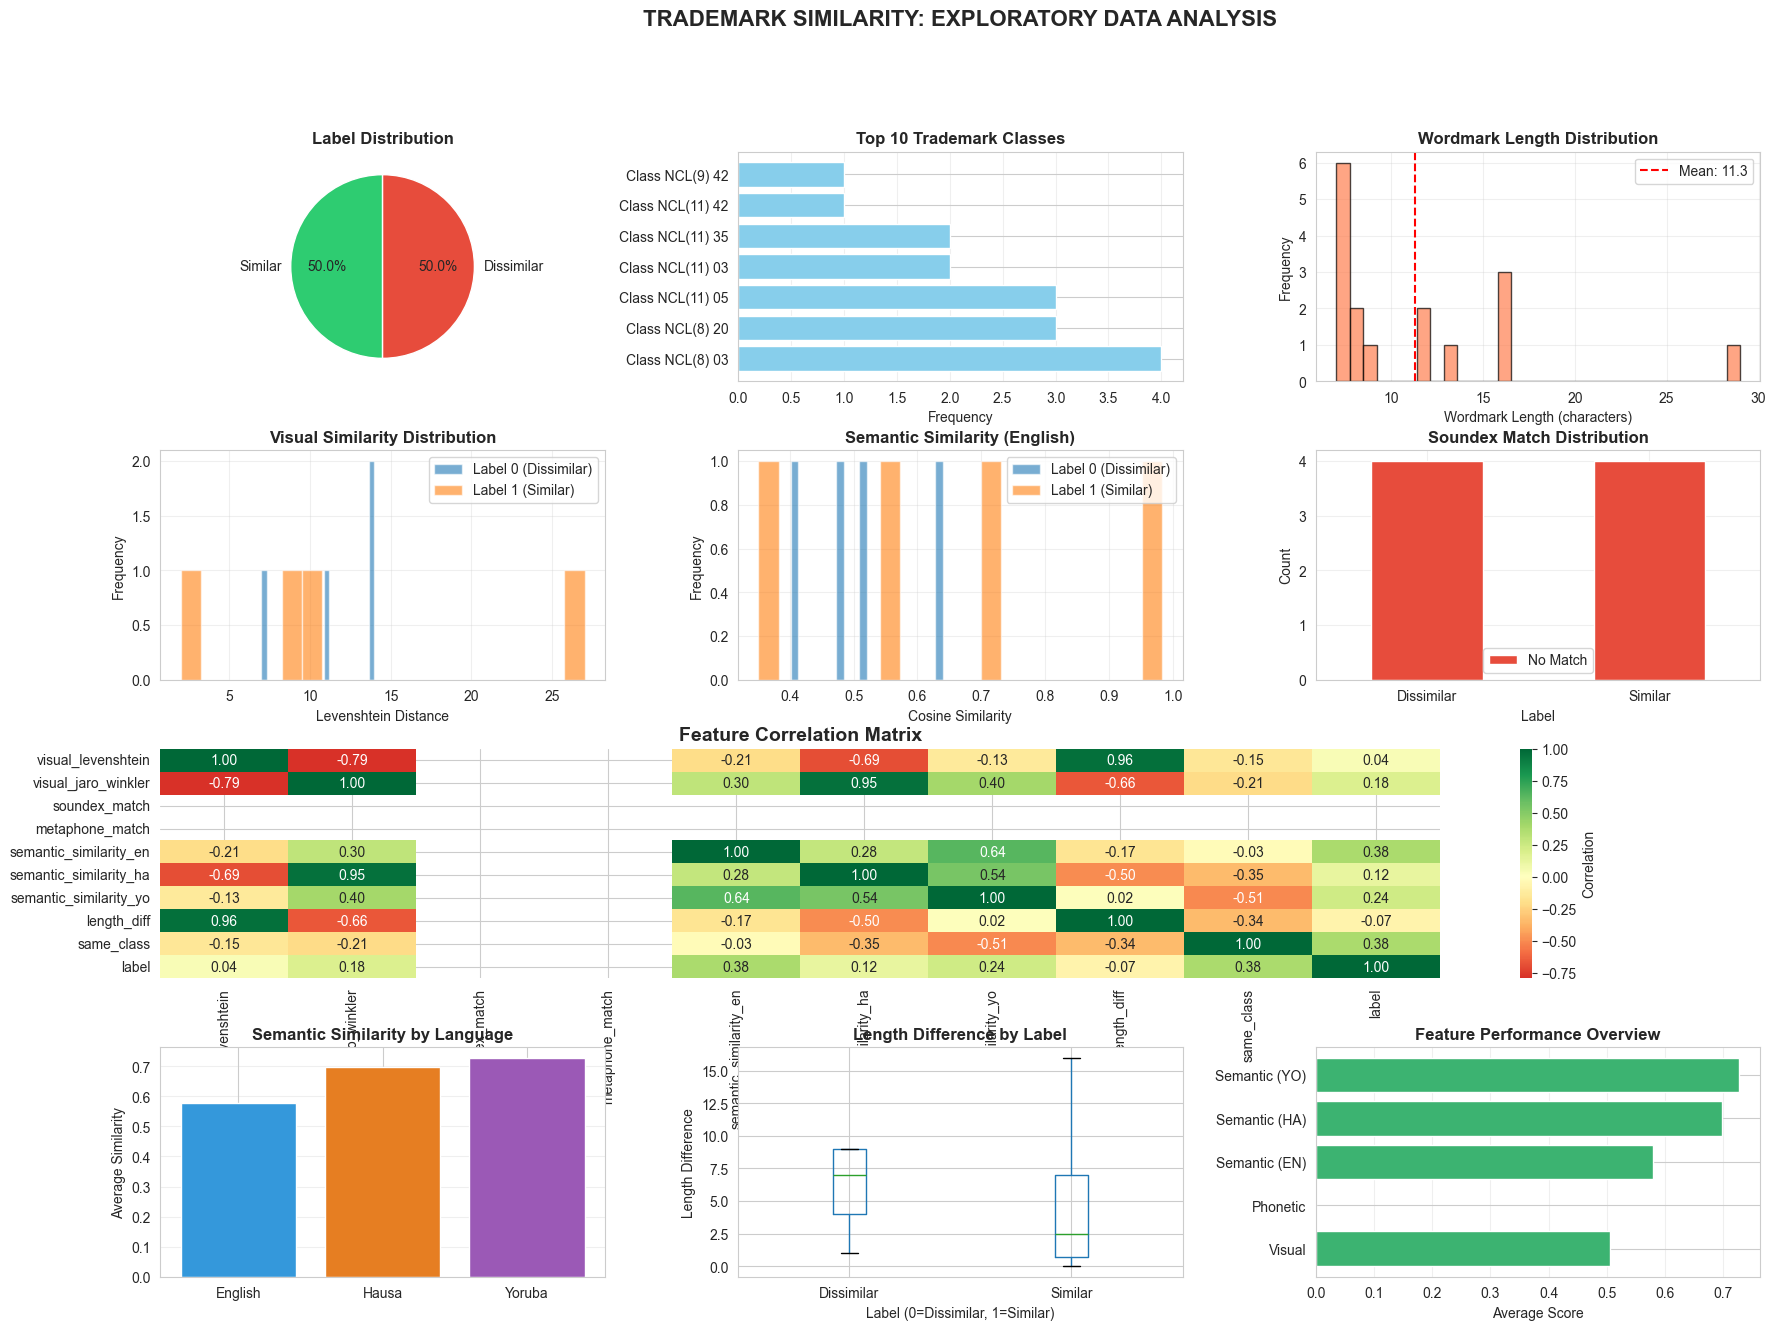

INFO: 
💾 Final dataset saved: trademark_similarity_dataset_final.csv
INFO:    Shape: (8, 27)
INFO:    File size: 0.00 MB



SAMPLE DATA (First 3 rows)
mark1_wordmark   mark2_wordmark  label  visual_levenshtein  soundex_match  semantic_similarity_en
  LIDER DESIGN LvÁDER ESTOFADOS      1                  10              0                0.351064
       COSENZA         SECPOWER      0                   7              0                0.639335
       KOLENZA          COSENZA      1                   2              0                0.983253

✅ STEP 1 COMPLETE - Ready for Step 2 (CNN Architecture)
   Use file: trademark_similarity_dataset_final.csv


In [2]:
# STEP 1: COMPLETE DATA PREPROCESSING & FEATURE ENGINEERING
# =============================================================================
# This notebook prepares trademark similarity data for CNN+SVM training
# Output: Single clean CSV with visual/phonetic/semantic features
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
import re
import logging
from dataclasses import dataclass
from deep_translator import GoogleTranslator
import chardet
import os
import warnings
import jellyfish
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# =============================================================================
# CONFIGURATION
# =============================================================================

TRADEMARK_LEXICON = {
    # Business & Commerce
    "company": {"ha": "kamfani", "yo": "ilé-iṣẹ́"},
    "business": {"ha": "kasuwanci", "yo": "iṣẹ́ owó"},
    "market": {"ha": "kasuwa", "yo": "ọjà"},
    "store": {"ha": "shago", "yo": "ṣọ́ọ̀bù"},
    "brand": {"ha": "alama", "yo": "àmì"},
    
    # Quality
    "premium": {"ha": "mai kyau", "yo": "iyebíye"},
    "super": {"ha": "babba", "yo": "púpọ̀"},
    "best": {"ha": "mafi kyau", "yo": "dára jùlọ"},
    "gold": {"ha": "zinariya", "yo": "wúrà"},
    "silver": {"ha": "azurfa", "yo": "fàdákà"},
    
    # Food & Beverage
    "coffee": {"ha": "kofi", "yo": "kọ́fí"},
    "tea": {"ha": "shayi", "yo": "tii"},
    "food": {"ha": "abinci", "yo": "oúnjẹ"},
    "restaurant": {"ha": "gidan cin abinci", "yo": "ilé oúnjẹ"},
    
    # Technology
    "tech": {"ha": "fasaha", "yo": "ìmọ̀-ẹrọ"},
    "digital": {"ha": "na dijital", "yo": "oníjìtù"},
    "smart": {"ha": "mai hankali", "yo": "ológbọ́n"},
    "online": {"ha": "kan layi", "yo": "lórí ayélujára"},
    
    # Common terms
    "new": {"ha": "sabon", "yo": "títun"},
    "fresh": {"ha": "sabo", "yo": "tuntun"},
    "natural": {"ha": "na halitta", "yo": "àdáyébá"},
}

@dataclass
class PreprocessingConfig:
    """Configuration for the entire pipeline"""
    # Data sampling
    max_rows: Optional[int] = None  # None = process all rows
    sampling_strategy: str = 'first'  # 'first', 'random', or 'all'
    
    # Translation
    translate_to_english: bool = True
    translate_to_local: bool = True
    
    # Cleaning
    fix_encoding: bool = True
    remove_duplicates: bool = True
    handle_missing: str = 'drop'
    
    # Negative pair generation
    negative_ratio: float = 1.0
    negative_strategy: str = 'mixed'
    
    # Output
    output_filename: str = 'trademark_similarity_dataset_final.csv'
    save_visualizations: bool = True

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def validate_wordmark(text: str) -> bool:
    """Check if a wordmark is valid (not empty/null)"""
    if pd.isna(text):
        return False
    text = str(text).strip()
    return len(text) > 0 and text.lower() not in ['nan', 'none', 'null', '']

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Remove all rows with invalid wordmarks"""
    initial_len = len(df)
    
    # Remove rows with missing/invalid wordmarks
    if 'mark1_wordmark' in df.columns and 'mark2_wordmark' in df.columns:
        df = df[
            df['mark1_wordmark'].apply(validate_wordmark) &
            df['mark2_wordmark'].apply(validate_wordmark)
        ].copy()
    
    removed = initial_len - len(df)
    if removed > 0:
        logger.info(f"🧹 Removed {removed} rows with invalid wordmarks")
    
    return df

# =============================================================================
# ENHANCED TRANSLATOR
# =============================================================================

class EnhancedTranslator:
    """Multi-strategy translator: Lexicon → HuggingFace → Google Translate"""
    
    def __init__(self):
        self.lexicon = TRADEMARK_LEXICON
        self.google_translators = {
            'ha': GoogleTranslator(source='en', target='ha'),
            'yo': GoogleTranslator(source='en', target='yo')
        }
        self.cache = {}
        self.stats = {'lexicon': 0, 'google': 0, 'cache': 0}
    
    def translate_word(self, word: str, target_lang: str) -> str:
        """Translate a single word"""
        if not word or not word.strip():
            return ""
        
        word_lower = word.lower().strip()
        cache_key = f"{target_lang}:{word_lower}"
        
        # Check cache
        if cache_key in self.cache:
            self.stats['cache'] += 1
            return self.cache[cache_key]
        
        # Try lexicon
        if word_lower in self.lexicon:
            translation = self.lexicon[word_lower].get(target_lang, word)
            self.stats['lexicon'] += 1
            self.cache[cache_key] = translation
            return translation
        
        # Fallback to Google Translate
        try:
            translation = self.google_translators[target_lang].translate(word)
            self.stats['google'] += 1
            self.cache[cache_key] = translation
            return translation
        except Exception:
            return word
    
    def translate_text(self, text: str, target_lang: str) -> str:
        """Translate full text"""
        if pd.isna(text) or not str(text).strip():
            return ""
        
        words = re.findall(r"\b\w+\b", str(text))
        translated = [self.translate_word(w, target_lang) for w in words]
        return " ".join(translated)

# =============================================================================
# FEATURE EXTRACTOR
# =============================================================================

class FeatureExtractor:
    """Extract visual, phonetic, and semantic features"""
    
    def __init__(self):
        self.semantic_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    
    def extract_visual_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract character-level visual similarity features"""
        logger.info("🔍 Extracting visual features...")
        
        df['visual_levenshtein'] = df.apply(
            lambda row: jellyfish.levenshtein_distance(
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ), axis=1
        )
        
        df['visual_jaro_winkler'] = df.apply(
            lambda row: jellyfish.jaro_winkler_similarity(
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ), axis=1
        )
        
        return df
    
    def extract_phonetic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract phonetic similarity features"""
        logger.info("👂 Extracting phonetic features...")
        
        df['soundex_match'] = df.apply(
            lambda row: int(
                jellyfish.soundex(str(row['mark1_wordmark'])) == 
                jellyfish.soundex(str(row['mark2_wordmark']))
            ), axis=1
        )
        
        df['metaphone_match'] = df.apply(
            lambda row: int(
                jellyfish.metaphone(str(row['mark1_wordmark'])) == 
                jellyfish.metaphone(str(row['mark2_wordmark']))
            ), axis=1
        )
        
        return df
    
    def _safe_encode(self, texts: List[str]) -> np.ndarray:
        """Safely encode texts handling NaN/empty values"""
        clean_texts = [str(t) if pd.notna(t) and str(t).strip() else "" for t in texts]
        return self.semantic_model.encode(clean_texts, show_progress_bar=False)
    
    def extract_semantic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract semantic similarity features for all languages"""
        logger.info("🧠 Extracting semantic features...")
        
        for lang in ['en', 'ha', 'yo']:
            col1 = f'mark1_wordmark_{lang}'
            col2 = f'mark2_wordmark_{lang}'
            
            if col1 in df.columns and col2 in df.columns:
                emb1 = self._safe_encode(df[col1].tolist())
                emb2 = self._safe_encode(df[col2].tolist())
                
                df[f'semantic_similarity_{lang}'] = [
                    float(cosine_similarity([e1], [e2])[0][0])
                    for e1, e2 in zip(emb1, emb2)
                ]
        
        return df
    
    def extract_all(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract all features"""
        df = self.extract_visual_features(df)
        df = self.extract_phonetic_features(df)
        df = self.extract_semantic_features(df)
        return df

# =============================================================================
# MAIN PREPROCESSOR
# =============================================================================

class TrademarkPreprocessor:
    """Complete preprocessing pipeline"""
    
    def __init__(self, config: PreprocessingConfig = None):
        self.config = config or PreprocessingConfig()
        self.translator = EnhancedTranslator()
        self.feature_extractor = FeatureExtractor()
        self.pt_to_en = GoogleTranslator(source='pt', target='en')
        self.cache = {}
    
    def load_data(self, file_path: str) -> pd.DataFrame:
        """Load CSV with encoding detection"""
        logger.info("📂 Loading dataset...")
        
        # Detect encoding
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read(100000))
        encoding = result['encoding']
        
        # Try multiple encodings
        for enc in [encoding, 'MacRoman', 'utf-8', 'latin-1']:
            try:
                df = pd.read_csv(file_path, encoding=enc)
                logger.info(f"✓ Loaded with encoding: {enc}")
                logger.info(f"   Shape: {df.shape}")
                return df
            except Exception:
                continue
        
        raise ValueError("Could not load CSV with any encoding")
    
    def extract_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract and rename relevant columns"""
        logger.info("📋 Extracting relevant columns...")
        
        column_mapping = {
            'Process number RM': 'mark1_id',
            'Process number TM': 'mark2_id',
            'Name RM': 'mark1_wordmark',
            'Name TM': 'mark2_wordmark',
            'Nice classification RM': 'mark1_class',
            'Nice classification TM': 'mark2_class',
            'Status RM': 'mark1_status',
            'Status TM': 'mark2_status',
        }
        
        available = [c for c in column_mapping.keys() if c in df.columns]
        df_proc = df[available].copy()
        df_proc.rename(columns=column_mapping, inplace=True)
        df_proc['label'] = 1  # All are similar pairs
        
        return df_proc
    
    def clean_text(self, text: str) -> str:
        """Clean text"""
        if pd.isna(text) or not str(text).strip():
            return ""
        
        text = str(text)
        
        # Fix encoding issues
        fixes = {
            'v�': 'ç', 'v�o': 'ção', 'v�': 'í', 'v=': 'ó', '?': ''
        }
        for bad, good in fixes.items():
            text = text.replace(bad, good)
        
        return ' '.join(text.split()).strip()
    
    def translate_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """Translate wordmarks to English, Hausa, Yoruba"""
        logger.info("🌍 Translating dataset...")
        
        for col in ['mark1_wordmark', 'mark2_wordmark']:
            if col not in df.columns:
                continue
            
            # Clean first
            df[col] = df[col].apply(self.clean_text)
            
            # Portuguese → English
            en_col = col.replace('_wordmark', '_wordmark_en')
            df[en_col] = df[col].apply(
                lambda x: self.pt_to_en.translate(x) if x else ""
            )
            
            # English → Hausa & Yoruba
            for lang in ['ha', 'yo']:
                lang_col = col.replace('_wordmark', f'_wordmark_{lang}')
                df[lang_col] = df[en_col].apply(
                    lambda x: self.translator.translate_text(x, lang)
                )
        
        # Show translation stats
        stats = self.translator.stats
        total = sum(stats.values())
        if total > 0:
            logger.info(f"   Lexicon: {stats['lexicon']} ({stats['lexicon']/total*100:.1f}%)")
            logger.info(f"   Google: {stats['google']} ({stats['google']/total*100:.1f}%)")
        
        return df
    
    def generate_negative_pairs(self, df: pd.DataFrame) -> pd.DataFrame:
        """Generate dissimilar pairs"""
        logger.info(f"🔄 Generating negative pairs (ratio: {self.config.negative_ratio})...")
        
        # Get valid wordmarks
        all_marks = list(set(
            df['mark1_wordmark'].tolist() + df['mark2_wordmark'].tolist()
        ))
        all_marks = [m for m in all_marks if validate_wordmark(m)]
        
        if len(all_marks) < 2:
            logger.warning("⚠ Not enough wordmarks for negative pairs")
            return pd.DataFrame()
        
        # Track classes
        classes = {}
        for _, row in df.iterrows():
            classes[row['mark1_wordmark']] = row['mark1_class']
            classes[row['mark2_wordmark']] = row['mark2_class']
        
        # Track existing pairs
        existing = set()
        for _, row in df.iterrows():
            pair = tuple(sorted([
                str(row['mark1_wordmark']),
                str(row['mark2_wordmark'])
            ]))
            existing.add(pair)
        
        # Generate negatives
        n_negative = int(len(df) * self.config.negative_ratio)
        negatives = []
        attempts = 0
        max_attempts = n_negative * 100
        
        while len(negatives) < n_negative and attempts < max_attempts:
            attempts += 1
            
            mark1 = np.random.choice(all_marks)
            mark2 = np.random.choice(all_marks)
            
            # Validate
            if mark1 == mark2:
                continue
            
            pair = tuple(sorted([mark1, mark2]))
            if pair in existing:
                continue
            
            # Strategy check
            if self.config.negative_strategy == 'mixed':
                class1 = classes.get(mark1, 0)
                class2 = classes.get(mark2, 0)
                len_diff = abs(len(mark1) - len(mark2))
                
                # Must be dissimilar in some way
                if not (class1 != class2 or len_diff > 3):
                    continue
            
            existing.add(pair)
            negatives.append({
                'mark1_wordmark': mark1,
                'mark2_wordmark': mark2,
                'mark1_class': classes.get(mark1, 0),
                'mark2_class': classes.get(mark2, 0),
                'label': 0,
                'pair_type': 'negative'
            })
        
        logger.info(f"✓ Generated {len(negatives)} negative pairs")
        return pd.DataFrame(negatives)
    
    def add_basic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add basic statistical features"""
        df['mark1_length'] = df['mark1_wordmark'].str.len()
        df['mark2_length'] = df['mark2_wordmark'].str.len()
        df['length_diff'] = abs(df['mark1_length'] - df['mark2_length'])
        df['same_class'] = (df['mark1_class'] == df['mark2_class']).astype(int)
        return df
    
    def process(self, file_path: str) -> pd.DataFrame:
        """Complete pipeline"""
        logger.info("=" * 80)
        logger.info("STEP 1: TRADEMARK SIMILARITY DATA PREPROCESSING")
        logger.info("=" * 80)
        
        # 1. Load
        df = self.load_data(file_path)
        
        # 2. Extract columns
        df = self.extract_columns(df)
        
        # 3. Sample (if configured)
        if self.config.max_rows and self.config.sampling_strategy != 'all':
            n = min(self.config.max_rows, len(df))
            if self.config.sampling_strategy == 'first':
                df = df.head(n).copy()
            elif self.config.sampling_strategy == 'random':
                df = df.sample(n=n, random_state=42).copy()
            logger.info(f"📝 Sampled {n} rows ({self.config.sampling_strategy})")
        
        # 4. Clean
        df = clean_dataframe(df)
        
        # 5. Remove duplicates
        initial = len(df)
        df['_pair_key'] = df.apply(
            lambda r: tuple(sorted([
                str(r['mark1_wordmark']),
                str(r['mark2_wordmark'])
            ])), axis=1
        )
        df = df.drop_duplicates(subset='_pair_key').drop('_pair_key', axis=1)
        logger.info(f"🗑️  Removed {initial - len(df)} duplicates")
        
        # 6. Translate
        df['pair_type'] = 'positive'
        df = self.translate_dataset(df)
        
        # 7. Generate negatives
        negative_df = self.generate_negative_pairs(df)
        
        if len(negative_df) > 0:
            # Translate negatives
            for col in ['mark1_wordmark', 'mark2_wordmark']:
                en_col = col.replace('_wordmark', '_wordmark_en')
                negative_df[en_col] = negative_df[col].apply(
                    lambda x: self.pt_to_en.translate(x) if x else ""
                )
                
                for lang in ['ha', 'yo']:
                    lang_col = col.replace('_wordmark', f'_wordmark_{lang}')
                    negative_df[lang_col] = negative_df[en_col].apply(
                        lambda x: self.translator.translate_text(x, lang)
                    )
            
            # Combine
            df = pd.concat([df, negative_df], ignore_index=True)
            df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # 8. Add features
        df = self.add_basic_features(df)
        df = self.feature_extractor.extract_all(df)
        
        # 9. Final cleaning
        df = clean_dataframe(df)
        
        logger.info("=" * 80)
        logger.info("✅ PREPROCESSING COMPLETE")
        logger.info(f"   Total pairs: {len(df)}")
        logger.info(f"   Positive: {(df['label']==1).sum()}")
        logger.info(f"   Negative: {(df['label']==0).sum()}")
        logger.info(f"   Features: {len(df.columns)}")
        logger.info("=" * 80)
        
        return df

# =============================================================================
# EXPLORATORY DATA ANALYSIS
# =============================================================================

class TrademarkEDA:
    """Comprehensive EDA with visualizations"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def create_visualizations(self, save_path: str = None):
        """Create all visualizations"""
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
        
        # 1. Label distribution
        ax1 = fig.add_subplot(gs[0, 0])
        label_counts = self.df['label'].value_counts()
        ax1.pie(label_counts.values, labels=['Similar', 'Dissimilar'], 
                autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
        ax1.set_title('Label Distribution', fontweight='bold', fontsize=12)
        
        # 2. Class distribution
        ax2 = fig.add_subplot(gs[0, 1])
        class_counts = pd.concat([
            self.df['mark1_class'], self.df['mark2_class']
        ]).value_counts().head(10)
        ax2.barh(range(len(class_counts)), class_counts.values, color='skyblue')
        ax2.set_yticks(range(len(class_counts)))
        ax2.set_yticklabels([f'Class {c}' for c in class_counts.index])
        ax2.set_xlabel('Frequency')
        ax2.set_title('Top 10 Trademark Classes', fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)
        
        # 3. Wordmark length distribution
        ax3 = fig.add_subplot(gs[0, 2])
        all_lengths = pd.concat([self.df['mark1_length'], self.df['mark2_length']])
        ax3.hist(all_lengths, bins=30, color='coral', edgecolor='black', alpha=0.7)
        ax3.axvline(all_lengths.mean(), color='red', linestyle='--', 
                    label=f'Mean: {all_lengths.mean():.1f}')
        ax3.set_xlabel('Wordmark Length (characters)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Wordmark Length Distribution', fontweight='bold')
        ax3.legend()
        ax3.grid(alpha=0.3)
        
        # 4. Visual similarity (Levenshtein)
        ax4 = fig.add_subplot(gs[1, 0])
        for label in [0, 1]:
            subset = self.df[self.df['label'] == label]['visual_levenshtein']
            ax4.hist(subset, bins=20, alpha=0.6, 
                    label=f'Label {label} ({"Similar" if label==1 else "Dissimilar"})')
        ax4.set_xlabel('Levenshtein Distance')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Visual Similarity Distribution', fontweight='bold')
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # 5. Semantic similarity (English)
        ax5 = fig.add_subplot(gs[1, 1])
        for label in [0, 1]:
            subset = self.df[self.df['label'] == label]['semantic_similarity_en']
            ax5.hist(subset, bins=20, alpha=0.6, 
                    label=f'Label {label} ({"Similar" if label==1 else "Dissimilar"})')
        ax5.set_xlabel('Cosine Similarity')
        ax5.set_ylabel('Frequency')
        ax5.set_title('Semantic Similarity (English)', fontweight='bold')
        ax5.legend()
        ax5.grid(alpha=0.3)
        
        # 6. Phonetic match
        ax6 = fig.add_subplot(gs[1, 2])
        soundex_counts = self.df.groupby(['label', 'soundex_match']).size().unstack(fill_value=0)
        soundex_counts.plot(kind='bar', ax=ax6, color=['#e74c3c', '#2ecc71'])
        ax6.set_xlabel('Label')
        ax6.set_ylabel('Count')
        ax6.set_title('Soundex Match Distribution', fontweight='bold')
        ax6.set_xticklabels(['Dissimilar', 'Similar'], rotation=0)
        ax6.legend(['No Match', 'Match'])
        ax6.grid(alpha=0.3)
        
        # 7. Feature correlation heatmap
        ax7 = fig.add_subplot(gs[2, :])
        feature_cols = [
            'visual_levenshtein', 'visual_jaro_winkler',
            'soundex_match', 'metaphone_match',
            'semantic_similarity_en', 'semantic_similarity_ha', 'semantic_similarity_yo',
            'length_diff', 'same_class', 'label'
        ]
        corr_data = self.df[feature_cols].corr()
        sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                   ax=ax7, cbar_kws={'label': 'Correlation'})
        ax7.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=14)
        
        # 8. Multilingual semantic similarity comparison
        ax8 = fig.add_subplot(gs[3, 0])
        langs = ['en', 'ha', 'yo']
        means = [self.df[f'semantic_similarity_{lang}'].mean() for lang in langs]
        ax8.bar(range(len(langs)), means, color=['#3498db', '#e67e22', '#9b59b6'])
        ax8.set_xticks(range(len(langs)))
        ax8.set_xticklabels(['English', 'Hausa', 'Yoruba'])
        ax8.set_ylabel('Average Similarity')
        ax8.set_title('Semantic Similarity by Language', fontweight='bold')
        ax8.grid(axis='y', alpha=0.3)
        
        # 9. Length difference by label
        ax9 = fig.add_subplot(gs[3, 1])
        self.df.boxplot(column='length_diff', by='label', ax=ax9)
        ax9.set_xlabel('Label (0=Dissimilar, 1=Similar)')
        ax9.set_ylabel('Length Difference')
        ax9.set_title('Length Difference by Label', fontweight='bold')
        plt.sca(ax9)
        plt.xticks([1, 2], ['Dissimilar', 'Similar'])
        
        # 10. Feature importance summary
        ax10 = fig.add_subplot(gs[3, 2])
        feature_stats = {
            'Visual': self.df['visual_jaro_winkler'].mean(),
            'Phonetic': (self.df['soundex_match'].mean() + self.df['metaphone_match'].mean()) / 2,
            'Semantic (EN)': self.df['semantic_similarity_en'].mean(),
            'Semantic (HA)': self.df['semantic_similarity_ha'].mean(),
            'Semantic (YO)': self.df['semantic_similarity_yo'].mean(),
        }
        ax10.barh(list(feature_stats.keys()), list(feature_stats.values()), 
                 color='mediumseagreen')
        ax10.set_xlabel('Average Score')
        ax10.set_title('Feature Performance Overview', fontweight='bold')
        ax10.grid(axis='x', alpha=0.3)
        
        plt.suptitle('TRADEMARK SIMILARITY: EXPLORATORY DATA ANALYSIS', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"📊 Visualizations saved to: {save_path}")
        
        plt.tight_layout()
        plt.show()
    
    def print_statistics(self):
        """Print detailed statistics"""
        print("\n" + "=" * 80)
        print("DATASET STATISTICS")
        print("=" * 80)
        
        print(f"\n📊 Dataset Overview:")
        print(f"   Total pairs: {len(self.df):,}")
        print(f"   Similar pairs: {(self.df['label']==1).sum():,} ({(self.df['label']==1).mean()*100:.1f}%)")
        print(f"   Dissimilar pairs: {(self.df['label']==0).sum():,} ({(self.df['label']==0).mean()*100:.1f}%)")
        print(f"   Total features: {len(self.df.columns)}")
        
        print(f"\n📏 Wordmark Statistics:")
        print(f"   Average length: {self.df['mark1_length'].mean():.1f} characters")
        print(f"   Min length: {self.df['mark1_length'].min()}")
        print(f"   Max length: {self.df['mark1_length'].max()}")
        
        print(f"\n🎯 Feature Quality:")
        print(f"   Visual similarity (Jaro-Winkler): {self.df['visual_jaro_winkler'].mean():.3f}")
        print(f"   Phonetic match rate: {self.df['soundex_match'].mean()*100:.1f}%")
        print(f"   Semantic similarity (EN): {self.df['semantic_similarity_en'].mean():.3f}")
        print(f"   Semantic similarity (HA): {self.df['semantic_similarity_ha'].mean():.3f}")
        print(f"   Semantic similarity (YO): {self.df['semantic_similarity_yo'].mean():.3f}")
        
        print(f"\n🏷️  Class Distribution:")
        top_classes = pd.concat([
            self.df['mark1_class'], self.df['mark2_class']
        ]).value_counts().head(5)
        for cls, count in top_classes.items():
            print(f"   Class {cls}: {count:,} occurrences")
        
        print("\n" + "=" * 80)

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Run complete pipeline"""
    
    # Configuration
    config = PreprocessingConfig(
        max_rows=5,  # Set to None to process all data
        sampling_strategy='random',
        negative_ratio=1.0,
        negative_strategy='mixed',
        output_filename='trademark_similarity_dataset_final.csv',
        save_visualizations=True
    )
    
    # Process
    preprocessor = TrademarkPreprocessor(config)
    df = preprocessor.process('trademark_file.csv')
    
    # EDA
    eda = TrademarkEDA(df)
    eda.print_statistics()
    eda.create_visualizations('trademark_eda_visualizations.png')
    
    # Save final dataset
    df.to_csv(config.output_filename, index=False, encoding='utf-8')
    logger.info(f"\n💾 Final dataset saved: {config.output_filename}")
    logger.info(f"   Shape: {df.shape}")
    logger.info(f"   File size: {os.path.getsize(config.output_filename) / 1024**2:.2f} MB")
    
    # Show sample
    print("\n" + "=" * 80)
    print("SAMPLE DATA (First 3 rows)")
    print("=" * 80)
    display_cols = [
        'mark1_wordmark', 'mark2_wordmark', 'label',
        'visual_levenshtein', 'soundex_match', 'semantic_similarity_en'
    ]
    print(df[display_cols].head(3).to_string(index=False))
    
    print("\n✅ STEP 1 COMPLETE - Ready for Step 2 (CNN Architecture)")
    print(f"   Use file: {config.output_filename}")
    
    return df

# Run pipeline
if __name__ == "__main__":
    final_df = main()

In [7]:
# STEP 1: COMPLETE DATA PREPROCESSING & FEATURE ENGINEERING
# =============================================================================
# This notebook prepares trademark similarity data for CNN+SVM training
# Output: Single clean CSV with visual/phonetic/semantic features
# =============================================================================

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
import re
import logging
from dataclasses import dataclass
from deep_translator import GoogleTranslator
import chardet
import os
import warnings
import jellyfish
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# =============================================================================
# CONFIGURATION
# =============================================================================

TRADEMARK_LEXICON = {
    # Business & Commerce
    "company": {"ha": "kamfani", "yo": "ilé-iṣẹ́"},
    "business": {"ha": "kasuwanci", "yo": "iṣẹ́ owó"},
    "market": {"ha": "kasuwa", "yo": "ọjà"},
    "store": {"ha": "shago", "yo": "ṣọ́ọ̀bù"},
    "brand": {"ha": "alama", "yo": "àmì"},
    
    # Quality
    "premium": {"ha": "mai kyau", "yo": "iyebíye"},
    "super": {"ha": "babba", "yo": "púpọ̀"},
    "best": {"ha": "mafi kyau", "yo": "dára jùlọ"},
    "gold": {"ha": "zinariya", "yo": "wúrà"},
    "silver": {"ha": "azurfa", "yo": "fàdákà"},
    
    # Food & Beverage
    "coffee": {"ha": "kofi", "yo": "kọ́fí"},
    "tea": {"ha": "shayi", "yo": "tii"},
    "food": {"ha": "abinci", "yo": "oúnjẹ"},
    "restaurant": {"ha": "gidan cin abinci", "yo": "ilé oúnjẹ"},
    
    # Technology
    "tech": {"ha": "fasaha", "yo": "ìmọ̀-ẹrọ"},
    "digital": {"ha": "na dijital", "yo": "oníjìtù"},
    "smart": {"ha": "mai hankali", "yo": "ológbọ́n"},
    "online": {"ha": "kan layi", "yo": "lórí ayélujára"},
    
    # Common terms
    "new": {"ha": "sabon", "yo": "títun"},
    "fresh": {"ha": "sabo", "yo": "tuntun"},
    "natural": {"ha": "na halitta", "yo": "àdáyébá"},
}

def get_incremented_filename(base_name: str) -> str:
    """
    Returns a filename that doesn't exist yet by appending _1, _2, etc.
    Example: 'data.csv' → 'data_1.csv' if 'data.csv' exists.
    """
    if not os.path.exists(base_name):
        return base_name

    name, ext = os.path.splitext(base_name)
    counter = 1
    while True:
        new_name = f"{name}_{counter}{ext}"
        if not os.path.exists(new_name):
            return new_name
        counter += 1

@dataclass
class PreprocessingConfig:
    """Configuration for the entire pipeline"""
    # Data sampling
    max_rows: Optional[int] = None  # None = process all rows
    sampling_strategy: str = 'first'  # 'first', 'random', or 'all'
    
    # Translation
    translate_to_english: bool = True
    translate_to_local: bool = True
    
    # Cleaning
    fix_encoding: bool = True
    remove_duplicates: bool = True
    handle_missing: str = 'drop'
    
    # Negative pair generation
    negative_ratio: float = 1.0
    negative_strategy: str = 'mixed'
    
    # Output
    output_filename: str = 'trademark_similarity_dataset_final.csv'
    save_visualizations: bool = True

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def validate_wordmark(text: str) -> bool:
    """Check if a wordmark is valid (not empty/null)"""
    if pd.isna(text):
        return False
    text = str(text).strip()
    return len(text) > 0 and text.lower() not in ['nan', 'none', 'null', '']

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Remove all rows with invalid wordmarks"""
    initial_len = len(df)
    
    # Remove rows with missing/invalid wordmarks
    if 'mark1_wordmark' in df.columns and 'mark2_wordmark' in df.columns:
        df = df[
            df['mark1_wordmark'].apply(validate_wordmark) &
            df['mark2_wordmark'].apply(validate_wordmark)
        ].copy()
    
    removed = initial_len - len(df)
    if removed > 0:
        logger.info(f"🧹 Removed {removed} rows with invalid wordmarks")
    
    return df

# =============================================================================
# ENHANCED TRANSLATOR
# =============================================================================

class EnhancedTranslator:
    """Multi-strategy translator: Lexicon → HuggingFace → Google Translate"""
    
    def __init__(self):
        self.lexicon = TRADEMARK_LEXICON
        self.google_translators = {
            'ha': GoogleTranslator(source='en', target='ha'),
            'yo': GoogleTranslator(source='en', target='yo')
        }
        self.cache = {}
        self.stats = {'lexicon': 0, 'google': 0, 'cache': 0}
    
    def translate_word(self, word: str, target_lang: str) -> str:
        """Translate a single word"""
        if not word or not word.strip():
            return ""
        
        word_lower = word.lower().strip()
        cache_key = f"{target_lang}:{word_lower}"
        
        # Check cache
        if cache_key in self.cache:
            self.stats['cache'] += 1
            return self.cache[cache_key]
        
        # Try lexicon
        if word_lower in self.lexicon:
            translation = self.lexicon[word_lower].get(target_lang, word)
            self.stats['lexicon'] += 1
            self.cache[cache_key] = translation
            return translation
        
        # Fallback to Google Translate
        try:
            translation = self.google_translators[target_lang].translate(word)
            self.stats['google'] += 1
            self.cache[cache_key] = translation
            return translation
        except Exception:
            return word
    
    def translate_text(self, text: str, target_lang: str) -> str:
        """Translate full text"""
        if pd.isna(text) or not str(text).strip():
            return ""
        
        words = re.findall(r"\b\w+\b", str(text))
        translated = [self.translate_word(w, target_lang) for w in words]
        return " ".join(translated)

# =============================================================================
# FEATURE EXTRACTOR (FIXED PHONETIC FEATURES)
# =============================================================================

class FeatureExtractor:
    """Extract visual, phonetic, and semantic features"""
    
    def __init__(self):
        self.semantic_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    
    def extract_visual_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract character-level visual similarity features"""
        logger.info("🔍 Extracting visual features...")
        
        df['visual_levenshtein'] = df.apply(
            lambda row: jellyfish.levenshtein_distance(
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ), axis=1
        )
        
        df['visual_jaro_winkler'] = df.apply(
            lambda row: jellyfish.jaro_winkler_similarity(
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ), axis=1
        )
        
        return df
    
    def extract_phonetic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract phonetic similarity features
        FIXED: Now uses English translations for better phonetic matching
        """
        logger.info("👂 Extracting phonetic features...")
        
        # Use English translations for phonetic comparison
        def safe_soundex(text):
            try:
                if pd.isna(text) or not str(text).strip():
                    return ""
                return jellyfish.soundex(str(text))
            except:
                return ""
        
        def safe_metaphone(text):
            try:
                if pd.isna(text) or not str(text).strip():
                    return ""
                return jellyfish.metaphone(str(text))
            except:
                return ""
        
        # Soundex comparison on English wordmarks
        df['soundex_match'] = df.apply(
            lambda row: int(
                safe_soundex(row.get('mark1_wordmark_en', '')) == 
                safe_soundex(row.get('mark2_wordmark_en', ''))
                and safe_soundex(row.get('mark1_wordmark_en', '')) != ""
            ), axis=1
        )
        
        # Metaphone comparison on English wordmarks
        df['metaphone_match'] = df.apply(
            lambda row: int(
                safe_metaphone(row.get('mark1_wordmark_en', '')) == 
                safe_metaphone(row.get('mark2_wordmark_en', ''))
                and safe_metaphone(row.get('mark1_wordmark_en', '')) != ""
            ), axis=1
        )
        
        return df
    
    def _safe_encode(self, texts: List[str]) -> np.ndarray:
        """Safely encode texts handling NaN/empty values"""
        clean_texts = [str(t) if pd.notna(t) and str(t).strip() else "" for t in texts]
        return self.semantic_model.encode(clean_texts, show_progress_bar=False)
    
    def extract_semantic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract semantic similarity features for all languages"""
        logger.info("🧠 Extracting semantic features...")
        
        for lang in ['en', 'ha', 'yo']:
            col1 = f'mark1_wordmark_{lang}'
            col2 = f'mark2_wordmark_{lang}'
            
            if col1 in df.columns and col2 in df.columns:
                emb1 = self._safe_encode(df[col1].tolist())
                emb2 = self._safe_encode(df[col2].tolist())
                
                df[f'semantic_similarity_{lang}'] = [
                    float(cosine_similarity([e1], [e2])[0][0])
                    for e1, e2 in zip(emb1, emb2)
                ]
        
        return df
    
    def extract_all(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract all features"""
        df = self.extract_visual_features(df)
        df = self.extract_phonetic_features(df)
        df = self.extract_semantic_features(df)
        return df

# =============================================================================
# MAIN PREPROCESSOR
# =============================================================================

class TrademarkPreprocessor:
    """Complete preprocessing pipeline"""
    
    def __init__(self, config: PreprocessingConfig = None):
        self.config = config or PreprocessingConfig()
        self.translator = EnhancedTranslator()
        self.feature_extractor = FeatureExtractor()
        self.pt_to_en = GoogleTranslator(source='pt', target='en')
        self.cache = {}
    
    def load_data(self, file_path: str) -> pd.DataFrame:
        """Load CSV with encoding detection"""
        logger.info("📂 Loading dataset...")
        
        # Detect encoding
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read(100000))
        encoding = result['encoding']
        
        # Try multiple encodings
        for enc in [encoding, 'MacRoman', 'utf-8', 'latin-1']:
            try:
                df = pd.read_csv(file_path, encoding=enc)
                logger.info(f"✓ Loaded with encoding: {enc}")
                logger.info(f"   Shape: {df.shape}")
                return df
            except Exception:
                continue
        
        raise ValueError("Could not load CSV with any encoding")
    
    def extract_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract and rename relevant columns (excluding class info)"""
        logger.info("📋 Extracting relevant columns...")
        
        column_mapping = {
            'Process number RM': 'mark1_id',
            'Process number TM': 'mark2_id',
            'Name RM': 'mark1_wordmark',
            'Name TM': 'mark2_wordmark',
            'Status RM': 'mark1_status',
            'Status TM': 'mark2_status',
        }
        
        available = [c for c in column_mapping.keys() if c in df.columns]
        df_proc = df[available].copy()
        df_proc.rename(columns=column_mapping, inplace=True)
        df_proc['label'] = 1  # All are similar pairs
        
        return df_proc
    
    def clean_text(self, text: str) -> str:
        """Clean text"""
        if pd.isna(text) or not str(text).strip():
            return ""
        
        text = str(text)
        
        # Fix encoding issues
        fixes = {
            'v�': 'ç', 'v�o': 'ção', 'v�': 'í', 'v=': 'ó', '?': ''
        }
        for bad, good in fixes.items():
            text = text.replace(bad, good)
        
        return ' '.join(text.split()).strip()
    
    def translate_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """Translate wordmarks to English, Hausa, Yoruba"""
        logger.info("🌍 Translating dataset...")
        
        for col in ['mark1_wordmark', 'mark2_wordmark']:
            if col not in df.columns:
                continue
            
            # Clean first
            df[col] = df[col].apply(self.clean_text)
            
            # Portuguese → English
            en_col = col.replace('_wordmark', '_wordmark_en')
            df[en_col] = df[col].apply(
                lambda x: self.pt_to_en.translate(x) if x else ""
            )
            
            # English → Hausa & Yoruba
            for lang in ['ha', 'yo']:
                lang_col = col.replace('_wordmark', f'_wordmark_{lang}')
                df[lang_col] = df[en_col].apply(
                    lambda x: self.translator.translate_text(x, lang)
                )
        
        # Show translation stats
        stats = self.translator.stats
        total = sum(stats.values())
        if total > 0:
            logger.info(f"   Lexicon: {stats['lexicon']} ({stats['lexicon']/total*100:.1f}%)")
            logger.info(f"   Google: {stats['google']} ({stats['google']/total*100:.1f}%)")
        
        return df
    
    def generate_negative_pairs(self, df: pd.DataFrame) -> pd.DataFrame:
        """Generate dissimilar pairs (without class filtering)"""
        logger.info(f"🔄 Generating negative pairs (ratio: {self.config.negative_ratio})...")
        
        # Get valid wordmarks
        all_marks = list(set(
            df['mark1_wordmark'].tolist() + df['mark2_wordmark'].tolist()
        ))
        all_marks = [m for m in all_marks if validate_wordmark(m)]
        
        if len(all_marks) < 2:
            logger.warning("⚠ Not enough wordmarks for negative pairs")
            return pd.DataFrame()
        
        # Track existing pairs
        existing = set()
        for _, row in df.iterrows():
            pair = tuple(sorted([
                str(row['mark1_wordmark']),
                str(row['mark2_wordmark'])
            ]))
            existing.add(pair)
        
        # Generate negatives
        n_negative = int(len(df) * self.config.negative_ratio)
        negatives = []
        attempts = 0
        max_attempts = n_negative * 100
        
        while len(negatives) < n_negative and attempts < max_attempts:
            attempts += 1
            
            mark1 = np.random.choice(all_marks)
            mark2 = np.random.choice(all_marks)
            
            # Validate
            if mark1 == mark2:
                continue
            
            pair = tuple(sorted([mark1, mark2]))
            if pair in existing:
                continue
            
            # Length difference check for dissimilarity
            if self.config.negative_strategy == 'mixed':
                len_diff = abs(len(mark1) - len(mark2))
                if len_diff < 3:  # Must have some length difference
                    continue
            
            existing.add(pair)
            negatives.append({
                'mark1_wordmark': mark1,
                'mark2_wordmark': mark2,
                'label': 0,
                'pair_type': 'negative'
            })
        
        logger.info(f"✓ Generated {len(negatives)} negative pairs")
        return pd.DataFrame(negatives)
    
    def add_basic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add basic statistical features"""
        df['mark1_length'] = df['mark1_wordmark'].str.len()
        df['mark2_length'] = df['mark2_wordmark'].str.len()
        df['length_diff'] = abs(df['mark1_length'] - df['mark2_length'])
        return df
    
    def process(self, file_path: str) -> pd.DataFrame:
        """Complete pipeline"""
        logger.info("=" * 80)
        logger.info("STEP 1: TRADEMARK SIMILARITY DATA PREPROCESSING")
        logger.info("=" * 80)
        
        # 1. Load
        df = self.load_data(file_path)
        
        # 2. Extract columns (no class info)
        df = self.extract_columns(df)
        
        # 3. Sample (if configured)
        if self.config.max_rows and self.config.sampling_strategy != 'all':
            n = min(self.config.max_rows, len(df))
            if self.config.sampling_strategy == 'first':
                df = df.head(n).copy()
            elif self.config.sampling_strategy == 'random':
                df = df.sample(n=n, random_state=42).copy()
            logger.info(f"📝 Sampled {n} rows ({self.config.sampling_strategy})")
        
        # 4. Clean
        df = clean_dataframe(df)
        
        # 5. Remove duplicates
        initial = len(df)
        df['_pair_key'] = df.apply(
            lambda r: tuple(sorted([
                str(r['mark1_wordmark']),
                str(r['mark2_wordmark'])
            ])), axis=1
        )
        df = df.drop_duplicates(subset='_pair_key').drop('_pair_key', axis=1)
        logger.info(f"🗑️  Removed {initial - len(df)} duplicates")
        
        # 6. Translate
        df['pair_type'] = 'positive'
        df = self.translate_dataset(df)
        
        # 7. Generate negatives
        negative_df = self.generate_negative_pairs(df)
        
        if len(negative_df) > 0:
            # Translate negatives
            for col in ['mark1_wordmark', 'mark2_wordmark']:
                en_col = col.replace('_wordmark', '_wordmark_en')
                negative_df[en_col] = negative_df[col].apply(
                    lambda x: self.pt_to_en.translate(x) if x else ""
                )
                
                for lang in ['ha', 'yo']:
                    lang_col = col.replace('_wordmark', f'_wordmark_{lang}')
                    negative_df[lang_col] = negative_df[en_col].apply(
                        lambda x: self.translator.translate_text(x, lang)
                    )
            
            # Combine
            df = pd.concat([df, negative_df], ignore_index=True)
            df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # 8. Add features
        df = self.add_basic_features(df)
        df = self.feature_extractor.extract_all(df)
        
        # 9. Final cleaning
        df = clean_dataframe(df)
        
        logger.info("=" * 80)
        logger.info("✅ PREPROCESSING COMPLETE")
        logger.info(f"   Total pairs: {len(df)}")
        logger.info(f"   Positive: {(df['label']==1).sum()}")
        logger.info(f"   Negative: {(df['label']==0).sum()}")
        logger.info(f"   Features: {len(df.columns)}")
        logger.info("=" * 80)
        
        return df

# =============================================================================
# EXPLORATORY DATA ANALYSIS (SEPARATE VISUALIZATIONS)
# =============================================================================

class TrademarkEDA:
    """Comprehensive EDA with separate, readable visualizations"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def create_visualizations(self, output_dir: str = '.'):
        """Create separate visualization files for better readability"""
        os.makedirs(output_dir, exist_ok=True)
        
        # 1. Label Distribution
        self._plot_label_distribution(output_dir)
        
        # 2. Wordmark Length Distribution
        self._plot_length_distribution(output_dir)
        
        # 3. Visual Similarity Distribution
        self._plot_visual_similarity(output_dir)
        
        # 4. Phonetic Match Distribution
        self._plot_phonetic_matches(output_dir)
        
        # 5. Semantic Similarity by Language
        self._plot_semantic_similarity(output_dir)
        
        # 6. Feature Correlation Heatmap
        self._plot_correlation_heatmap(output_dir)
        
        # 7. Length Difference by Label
        self._plot_length_difference(output_dir)
        
        logger.info(f"📊 All visualizations saved to: {output_dir}/")
    
    def _plot_label_distribution(self, output_dir):
        fig, ax = plt.subplots(figsize=(8, 8))
        label_counts = self.df['label'].value_counts()
        colors = ['#2ecc71', '#e74c3c']
        ax.pie(label_counts.values, labels=['Similar', 'Dissimilar'], 
               autopct='%1.1f%%', startangle=90, colors=colors,
               textprops={'fontsize': 14, 'weight': 'bold'})
        ax.set_title('Label Distribution', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/01_label_distribution.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_length_distribution(self, output_dir):
        fig, ax = plt.subplots(figsize=(12, 6))
        all_lengths = pd.concat([self.df['mark1_length'], self.df['mark2_length']])
        ax.hist(all_lengths, bins=30, color='coral', edgecolor='black', alpha=0.7)
        ax.axvline(all_lengths.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {all_lengths.mean():.1f}')
        ax.set_xlabel('Wordmark Length (characters)', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('Wordmark Length Distribution', fontsize=16, fontweight='bold', pad=20)
        ax.legend(fontsize=12)
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/02_length_distribution.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_visual_similarity(self, output_dir):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Levenshtein
        for label in [0, 1]:
            subset = self.df[self.df['label'] == label]['visual_levenshtein']
            ax1.hist(subset, bins=20, alpha=0.6, 
                    label=f'{"Similar" if label==1 else "Dissimilar"}')
        ax1.set_xlabel('Levenshtein Distance', fontsize=12)
        ax1.set_ylabel('Frequency', fontsize=12)
        ax1.set_title('Visual Similarity: Levenshtein Distance', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(alpha=0.3)
        
        # Jaro-Winkler
        for label in [0, 1]:
            subset = self.df[self.df['label'] == label]['visual_jaro_winkler']
            ax2.hist(subset, bins=20, alpha=0.6, 
                    label=f'{"Similar" if label==1 else "Dissimilar"}')
        ax2.set_xlabel('Jaro-Winkler Similarity', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.set_title('Visual Similarity: Jaro-Winkler', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/03_visual_similarity.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_phonetic_matches(self, output_dir):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Soundex
        soundex_counts = self.df.groupby(['label', 'soundex_match']).size().unstack(fill_value=0)
        soundex_counts.plot(kind='bar', ax=ax1, color=['#e74c3c', '#2ecc71'])
        ax1.set_xlabel('Label', fontsize=12)
        ax1.set_ylabel('Count', fontsize=12)
        ax1.set_title('Phonetic Match: Soundex', fontsize=14, fontweight='bold')
        ax1.set_xticklabels(['Dissimilar', 'Similar'], rotation=0)
        ax1.legend(['No Match', 'Match'], fontsize=11)
        ax1.grid(alpha=0.3)
        
        # Metaphone
        metaphone_counts = self.df.groupby(['label', 'metaphone_match']).size().unstack(fill_value=0)
        metaphone_counts.plot(kind='bar', ax=ax2, color=['#e74c3c', '#2ecc71'])
        ax2.set_xlabel('Label', fontsize=12)
        ax2.set_ylabel('Count', fontsize=12)
        ax2.set_title('Phonetic Match: Metaphone', fontsize=14, fontweight='bold')
        ax2.set_xticklabels(['Dissimilar', 'Similar'], rotation=0)
        ax2.legend(['No Match', 'Match'], fontsize=11)
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/04_phonetic_matches.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_semantic_similarity(self, output_dir):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        langs = ['en', 'ha', 'yo']
        
        # Distributions by label for each language
        for idx, lang in enumerate(langs):
            row = idx // 2
            col = idx % 2
            ax = axes[row, col]
            
            for label in [0, 1]:
                subset = self.df[self.df['label'] == label][f'semantic_similarity_{lang}']
                ax.hist(subset, bins=20, alpha=0.6, 
                       label=f'{"Similar" if label==1 else "Dissimilar"}')
            
            lang_names = {'en': 'English', 'ha': 'Hausa', 'yo': 'Yoruba'}
            ax.set_xlabel('Cosine Similarity', fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.set_title(f'Semantic Similarity: {lang_names[lang]}', fontsize=14, fontweight='bold')
            ax.legend(fontsize=11)
            ax.grid(alpha=0.3)
        
        # Comparison bar chart
        ax = axes[1, 1]
        means = [self.df[f'semantic_similarity_{lang}'].mean() for lang in langs]
        colors = ['#3498db', '#e67e22', '#9b59b6']
        bars = ax.bar(['English', 'Hausa', 'Yoruba'], means, color=colors, alpha=0.7, edgecolor='black')
        ax.set_ylabel('Average Similarity', fontsize=12)
        ax.set_title('Semantic Similarity by Language', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/05_semantic_similarity.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_correlation_heatmap(self, output_dir):
        fig, ax = plt.subplots(figsize=(14, 12))
        
        feature_cols = [
            'visual_levenshtein', 'visual_jaro_winkler',
            'soundex_match', 'metaphone_match',
            'semantic_similarity_en', 'semantic_similarity_ha', 'semantic_similarity_yo',
            'length_diff', 'label'
        ]
        
        corr_data = self.df[feature_cols].corr()
        sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                   ax=ax, cbar_kws={'label': 'Correlation'}, 
                   square=True, linewidths=1)
        ax.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/06_correlation_heatmap.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_length_difference(self, output_dir):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        data_to_plot = [
            self.df[self.df['label'] == 0]['length_diff'],
            self.df[self.df['label'] == 1]['length_diff']
        ]
        
        bp = ax.boxplot(data_to_plot, labels=['Dissimilar', 'Similar'],
                       patch_artist=True, showmeans=True)
        
        colors = ['#e74c3c', '#2ecc71']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_xlabel('Label', fontsize=12)
        ax.set_ylabel('Length Difference', fontsize=12)
        ax.set_title('Length Difference by Label', fontsize=16, fontweight='bold', pad=20)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/07_length_difference.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def print_statistics(self):
        """Print detailed statistics"""
        print("\n" + "=" * 80)
        print("DATASET STATISTICS")
        print("=" * 80)
        
        print(f"\n📊 Dataset Overview:")
        print(f"   Total pairs: {len(self.df):,}")
        print(f"   Similar pairs: {(self.df['label']==1).sum():,} ({(self.df['label']==1).mean()*100:.1f}%)")
        print(f"   Dissimilar pairs: {(self.df['label']==0).sum():,} ({(self.df['label']==0).mean()*100:.1f}%)")
        print(f"   Total features: {len(self.df.columns)}")
        
        print(f"\n📏 Wordmark Statistics:")
        print(f"   Average length: {self.df['mark1_length'].mean():.1f} characters")
        print(f"   Min length: {self.df['mark1_length'].min()}")
        print(f"   Max length: {self.df['mark1_length'].max()}")
        
        print(f"\n🎯 Feature Quality:")
        print(f"   Visual similarity (Jaro-Winkler): {self.df['visual_jaro_winkler'].mean():.3f}")
        print(f"   Phonetic match rate (Soundex): {self.df['soundex_match'].mean()*100:.1f}%")
        print(f"   Phonetic match rate (Metaphone): {self.df['metaphone_match'].mean()*100:.1f}%")
        print(f"   Semantic similarity (EN): {self.df['semantic_similarity_en'].mean():.3f}")
        print(f"   Semantic similarity (HA): {self.df['semantic_similarity_ha'].mean():.3f}")
        print(f"   Semantic similarity (YO): {self.df['semantic_similarity_yo'].mean():.3f}")
        
        print("\n" + "=" * 80)

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Run complete pipeline"""
    
    # Configuration
    config = PreprocessingConfig(
        max_rows=5,  # Set to None to process all data
        sampling_strategy='random',
        negative_ratio=1.0,
        negative_strategy='mixed',
        output_filename='trademark_similarity_dataset_final.csv',
        save_visualizations=True
    )
    
    # Process
    preprocessor = TrademarkPreprocessor(config)
    df = preprocessor.process('trademark_file.csv')
    
    # EDA
    eda = TrademarkEDA(df)
    eda.print_statistics()
    
    if config.save_visualizations:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        viz_dir = f"eda_visualizations_{timestamp}"
        eda.create_visualizations(viz_dir)
    
    # Save final dataset
    # Generate a safe, non-overwriting filename
    safe_output_file = get_incremented_filename(config.output_filename)
    df.to_csv(safe_output_file, index=False, encoding='utf-8')
    logger.info(f"\n💾 Final dataset saved: {safe_output_file}")
    logger.info(f"   Shape: {df.shape}")
    logger.info(f"   File size: {os.path.getsize(safe_output_file) / 1024**2:.2f} MB")
    
    # Show sample
    print("\n" + "=" * 80)
    print("SAMPLE DATA (First 5 rows)")
    print("=" * 80)
    display_cols = [
        'mark1_wordmark', 'mark2_wordmark', 'label',
        'visual_levenshtein', 'soundex_match', 'metaphone_match', 'semantic_similarity_en'
    ]
    print(df[display_cols].head(5).to_string(index=False))
    
    print("\n✅ STEP 1 COMPLETE - Ready for Step 2 (CNN Architecture)")
    print(f"   Use file: {safe_output_file}")
    print(f"   Visualizations: {viz_dir} directory")
    
    return df

# Run pipeline
if __name__ == "__main__":
    final_df = main()

INFO: Use pytorch device_name: cpu
INFO: Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
INFO: ================================================================================
INFO: STEP 1: TRADEMARK SIMILARITY DATA PREPROCESSING
INFO: ================================================================================
INFO: 📂 Loading dataset...
INFO: ✓ Loaded with encoding: MacRoman
INFO:    Shape: (18737, 18)
INFO: 📋 Extracting relevant columns...
INFO: 📝 Sampled 5 rows (random)
INFO: 🧹 Removed 1 rows with invalid wordmarks
INFO: 🗑️  Removed 0 duplicates
INFO: 🌍 Translating dataset...
INFO:    Lexicon: 2 (6.7%)
INFO:    Google: 26 (86.7%)
INFO: 🔄 Generating negative pairs (ratio: 1.0)...
INFO: ✓ Generated 4 negative pairs
INFO: 🔍 Extracting visual features...
INFO: 👂 Extracting phonetic features...
INFO: 🧠 Extracting semantic features...
INFO: ================================================================================
INFO: ✅ PREPROCESSING COMPLETE
INFO:  


DATASET STATISTICS

📊 Dataset Overview:
   Total pairs: 8
   Similar pairs: 4 (50.0%)
   Dissimilar pairs: 4 (50.0%)
   Total features: 24

📏 Wordmark Statistics:
   Average length: 14.0 characters
   Min length: 7
   Max length: 29

🎯 Feature Quality:
   Visual similarity (Jaro-Winkler): 0.450
   Phonetic match rate (Soundex): 0.0%
   Phonetic match rate (Metaphone): 0.0%
   Semantic similarity (EN): 0.465
   Semantic similarity (HA): 0.618
   Semantic similarity (YO): 0.652



INFO: 📊 All visualizations saved to: eda_visualizations_20260122_114009/
INFO: 
💾 Final dataset saved: trademark_similarity_dataset_final_1.csv
INFO:    Shape: (8, 24)
INFO:    File size: 0.00 MB



SAMPLE DATA (First 5 rows)
               mark1_wordmark   mark2_wordmark  label  visual_levenshtein  soundex_match  metaphone_match  semantic_similarity_en
                 LIDER DESIGN LvÁDER ESTOFADOS      1                  10              0                0                0.351064
LIGHT ENGENHARIA E SOLUv·vÔES        Power Sek      0                  27              0                0                0.312772
                      KOLENZA          COSENZA      1                   2              0                0                0.983253
                     SECPOWER     LIDER DESIGN      0                  11              0                0                0.324333
                     SECPOWER        Power Sek      1                   9              0                0                0.565136

✅ STEP 1 COMPLETE - Ready for Step 2 (CNN Architecture)
   Use file: trademark_similarity_dataset_final_1.csv
   Visualizations: eda_visualizations_20260122_114009 directory
